# Characterize...

- Experimental branch points
- Test set performance
- Extrapolative performance

In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
cons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in cons: cons[chrom] = {}
        cons[chrom][int(pos)] = float(score)

In [4]:
introns = {}
with open('../preprocessing/introns_to_mercer.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

37110
169182


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

X, y, chroms, threes, strands = [], [], [], [], []
for intron, bps in known.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]
    if chrom == 'chr1':
        threes += [three]
        strands += [strand]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms), len(threes), len(strands)

(37110, 70, 5) (37110, 70) 37110 4306 4306


In [7]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

4306 7093 25711
(25711, 70, 5) (7093, 70, 5) (4306, 70, 5)
(25711, 70) (7093, 70) (4306, 70)


# Baseline models

In [8]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

def plot_examples(preds, true, k = 10):
    for p, t in zip(preds[:k], true[:k]):
        plt.plot(range(-70, 0), t, label = 'Mercer')
        plt.plot(range(-70, 0), p, label = 'Predictions')
        plt.legend(loc = 'best')
        plt.xlabel("Postion relative to 3'ss")
        plt.show()

def roc(X, y, model):
    truth = y[:, 15:45].flatten()
    
    scores = model.predict(X)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(X, pwm)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(X, dists)[:, 15:45].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.show()

# Conservation Meta

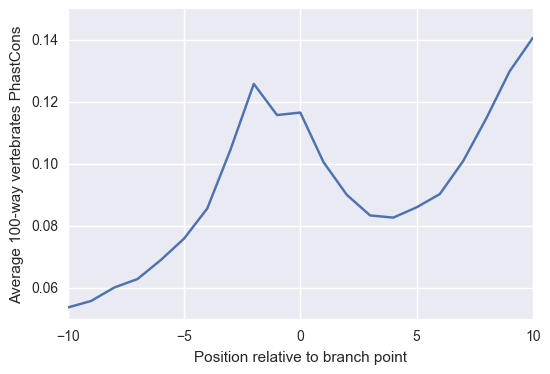

In [9]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhastCons')
plt.show()

# Dist Model

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    22.    25.    37.    41.    39.    47.    41.    47.    61.    77.
    82.    81.    92.    93.   140.   146.   185.   212.   230.   273.
   299.   386.   434.   497.   620.   735.   877.  1053.  1255.  1486.
  1770.  2073.  2261.  2496.  2712.  2872.  2790.  2860.  2567.  2140.
  1676.  1191.   775.   401.   258.   160.    96.    94.    71.    42.
    30.    24.    28.    30.    21.     0.     0.     0.     0.     0.]


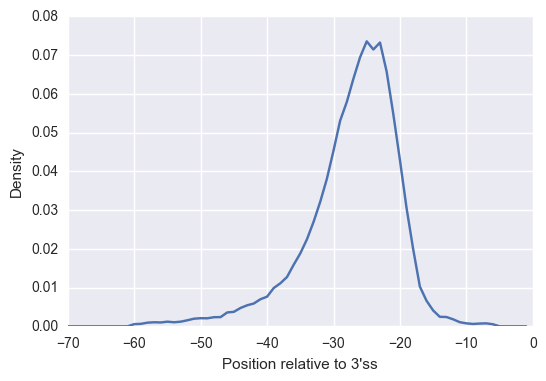

In [10]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        counts[bp] += 1
        total += 1
print counts
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

In [11]:
def dist_pred(X, dists):
    return np.vstack([dists.T] * X.shape[0])

print matching(dist_pred(X_test, dists), y_test)
print matching(dist_pred(X_train, dists), y_train)

(433, 4306)
(2872, 25711)


# PWM model

In [12]:
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm = counts / total

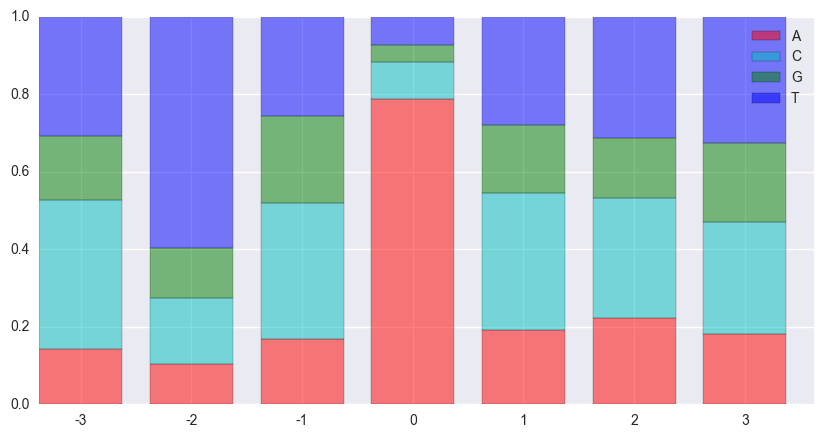

In [13]:
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
pwm_logo(pwm)

In [14]:
def pwm_pred(X, pwm):
    scores = []
    for seq in X:
        s = [0] * K
        for i in range(seq.shape[0] - K*2):
            s += [np.sum(seq[i:i+2*K+1, :4] * pwm)]
        s += [0] * K
        scores += [np.array(s)]
    return np.vstack(scores)

print matching(pwm_pred(X_test, pwm), y_test)
print matching(pwm_pred(X_train, pwm), y_train)

(1350, 4306)
(8539, 25711)


# Load model

In [15]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


# Model Performance

In [16]:
print y_train.shape[0], y_valid.shape[0], y_test.shape[0]

25711 7093 4306


# Compare to branchpointer

In [17]:
# All for chrom1
pos  = []
for line in open('../anno/branchpointer.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)

112451


In [18]:
bptr_preds = np.zeros((len(threes), 27))
for i, (three, strand) in enumerate(zip(threes, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    #if strand == '+':continue
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0

In [19]:
lstm_preds = model.predict(X_test[:, :, :4])[:, 25:25+27]

In [20]:
idx = np.max(bptr_preds, axis = 1) > 0
lstm_preds = lstm_preds[idx]
y_filt     = y_test[idx][:, 25:25+27]
bptr_preds = bptr_preds[idx]

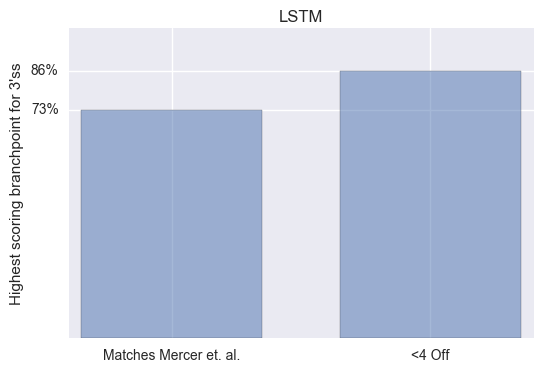

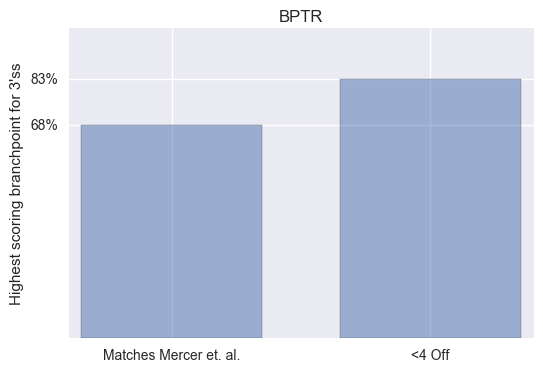

(2889, 619, 4197)

In [21]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, shifted = 0, 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        elif any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-E, np.argmax(p)+B+1)):
            shifted += 1
        total += 1
    heights = [match / float(total), (match+shifted) / float(total)]
    index = [0, .5]
    plt.bar(index, heights, .35, align = 'center', alpha = 0.5)
    plt.ylim(0, 1)
    plt.xticks(index, ['Matches Mercer et. al.', '<4 Off'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return match, shifted, total

shifted_matching(lstm_preds, y_filt, 'LSTM')
shifted_matching(bptr_preds, y_filt, 'BPTR')

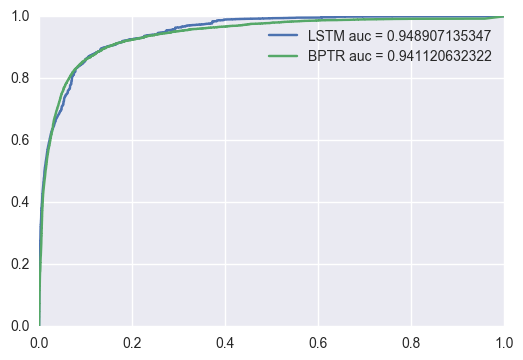

In [22]:
y_filt = y_filt.flatten()
lstm_preds = lstm_preds.flatten()
bptr_preds = bptr_preds.flatten()
fpr, tpr, thresholds = metrics.roc_curve(y_filt, lstm_preds, pos_label=1)
auc = metrics.roc_auc_score(y_filt, lstm_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))

fpr, tpr, thresholds = metrics.roc_curve(y_filt, bptr_preds, pos_label=1)
auc = metrics.roc_auc_score(y_filt, bptr_preds)
plt.plot(fpr, tpr, label = "BPTR auc = {}".format(auc))
plt.legend()
plt.show()

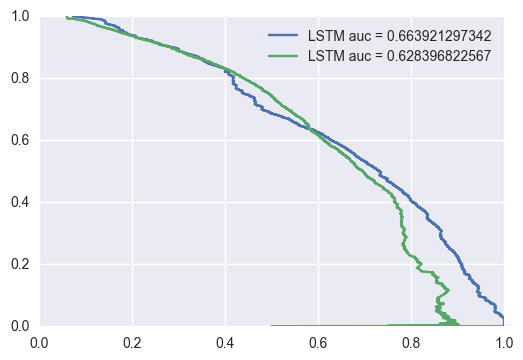

In [23]:
fpr, tpr, thresholds = metrics.precision_recall_curve(y_filt, lstm_preds, pos_label=1)
auc = metrics.average_precision_score(y_filt, lstm_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))

fpr, tpr, thresholds = metrics.precision_recall_curve(y_filt, bptr_preds, pos_label=1)
auc = metrics.average_precision_score(y_filt, bptr_preds)
plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
plt.legend()
plt.show()

## auROC on train, valid, test

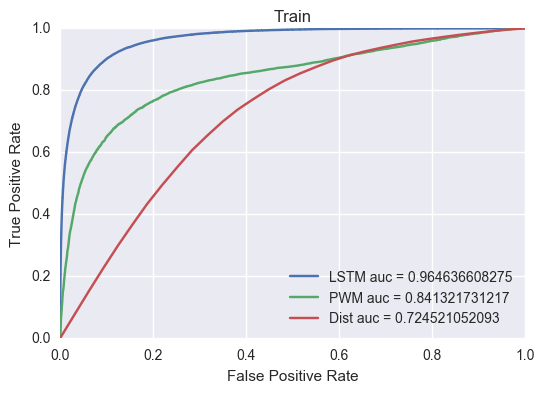

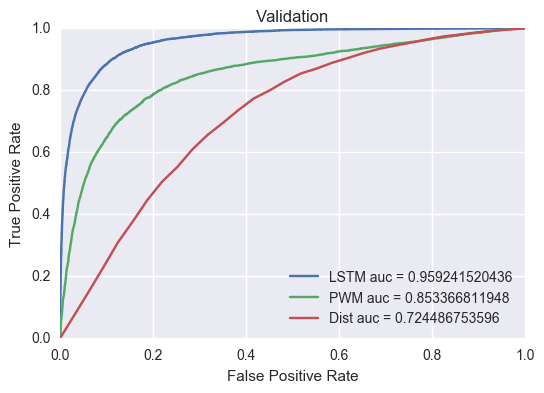

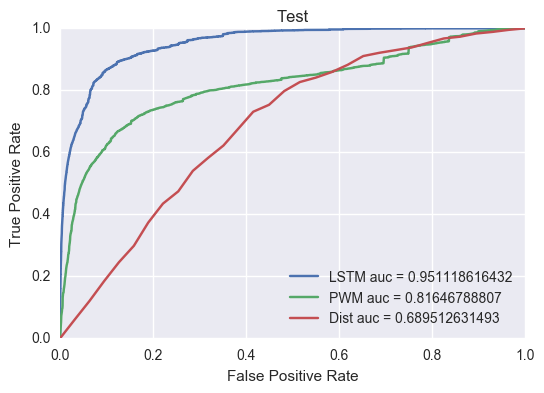

In [24]:
K=3
def roc(X, y, model, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    _y = y[np.sum(y[:, begin:end], axis = 1).flatten() > 0]
    _X = X[np.sum(y[:, begin:end], axis = 1).flatten() > 0]
    truth = _y[:, begin:end].flatten()
    
    scores = model.predict(_X)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
roc(X_train[:, :, :4], y_train.reshape(-1, 70, 1), model, 15, 45, 'Train')
roc(X_valid[:, :, :4], y_valid.reshape(-1, 70, 1), model, 15, 45, 'Validation')
roc(X_test[:, :, :4],  y_test.reshape(-1, 70, 1),  model, 15, 45, 'Test')

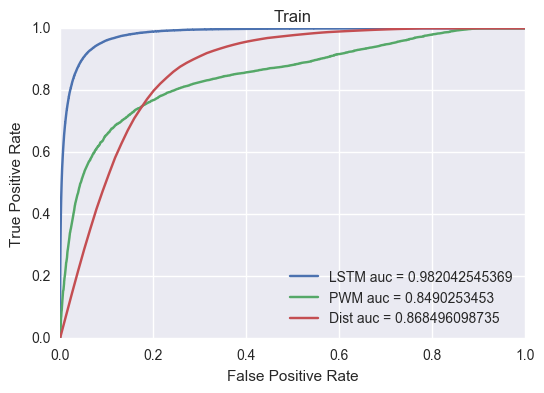

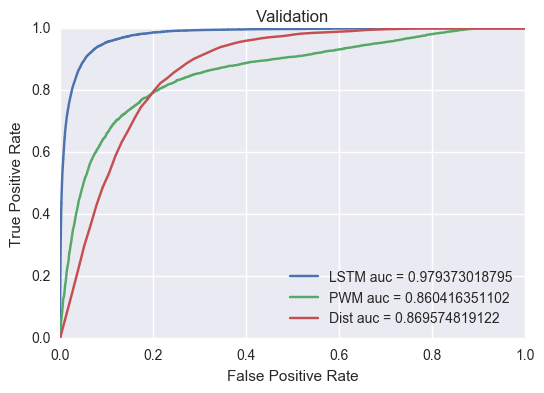

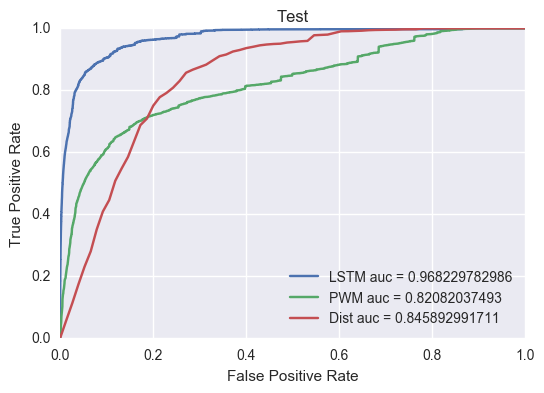

In [25]:
K=3
def roc(X, y, model, title):
    truth = y.flatten()
    scores = model.predict(X).flatten()

    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(X, pwm).flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(X, dists).flatten()
    fpr, tpr, thresholds = metrics.roc_curve(truth, scores, pos_label=1)
    auc = metrics.roc_auc_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
roc(X_train[:, :, :4], y_train.reshape(-1, 70, 1), model, 'Train')
roc(X_valid[:, :, :4], y_valid.reshape(-1, 70, 1), model, 'Validation')
roc(X_test[:, :, :4],  y_test.reshape(-1, 70, 1),  model, 'Test')

## auPRC on train, valid, test

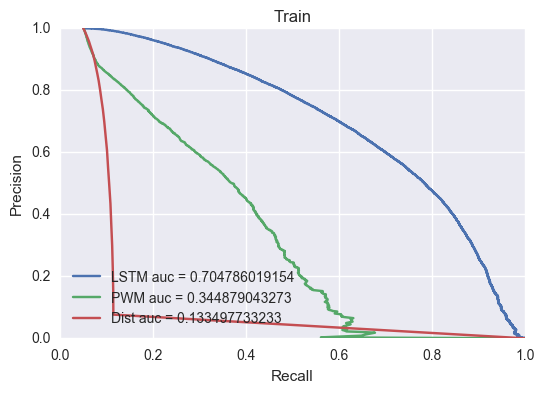

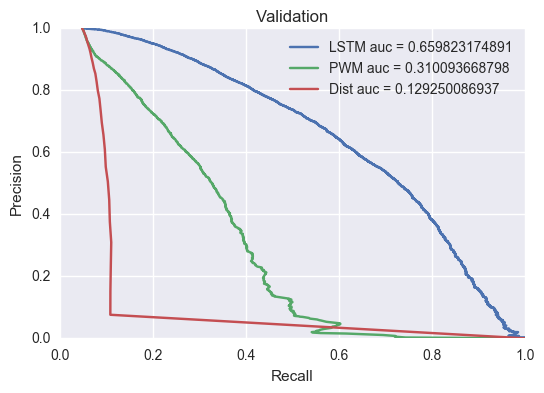

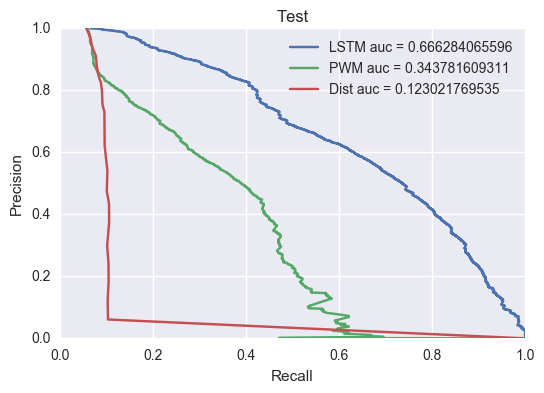

In [26]:
def roc(X, y, model, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    _y = y[np.sum(y[:, begin:end], axis = 1).flatten() > 0]
    _X = X[np.sum(y[:, begin:end], axis = 1).flatten() > 0]
    truth = _y[:, begin:end].flatten()
    
    scores = model.predict(_X)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth,scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "LSTM auc = {}".format(auc))
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth, scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc))
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth, scores, pos_label=1)
    auc = metrics.average_precision_score(truth, scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc))
    
    plt.legend(loc = 'best')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(title)
    plt.show()
    
roc(X_train[:, :, :4], y_train.reshape(-1, 70, 1), model, 15, 45, 'Train')
roc(X_valid[:, :, :4], y_valid.reshape(-1, 70, 1), model, 15, 45, 'Validation')
roc(X_test[:, :, :4],  y_test.reshape(-1, 70, 1),  model, 15, 45, 'Test')

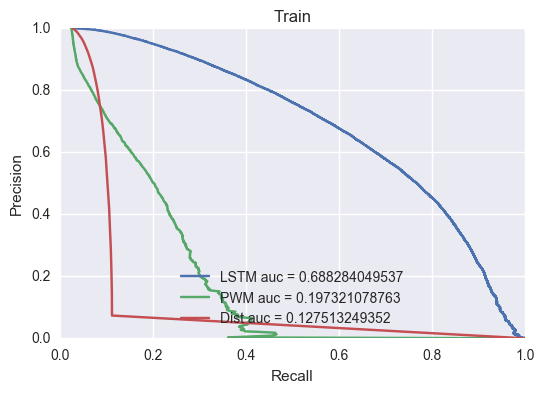

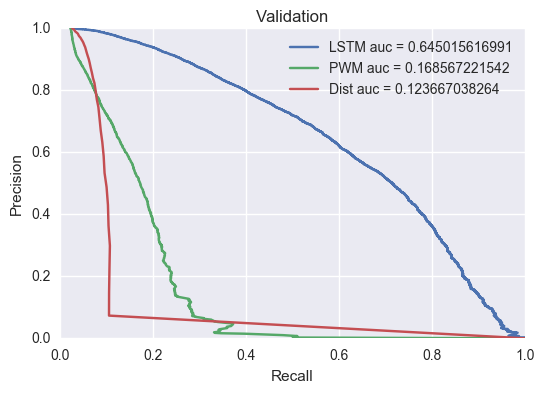

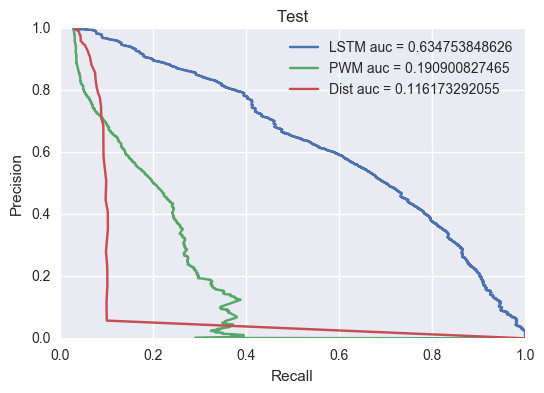

In [27]:
roc(X_train[:, :, :4], y_train.reshape(-1, 70, 1), model, 0, 70, 'Train')
roc(X_valid[:, :, :4], y_valid.reshape(-1, 70, 1), model, 0, 70, 'Validation')
roc(X_test[:, :, :4],  y_test.reshape(-1, 70, 1),  model, 0, 70, 'Test')

## Match on train, valid, test

In [28]:
print matching(model.predict(X_train[:, :, :4]), y_train)
print matching(model.predict(X_valid[:, :, :4]), y_valid)
print matching(model.predict(X_test[:, :, :4]),  y_test)        

(19402, 25711)
(5028, 7093)
(3234, 4306)


# Bar charts

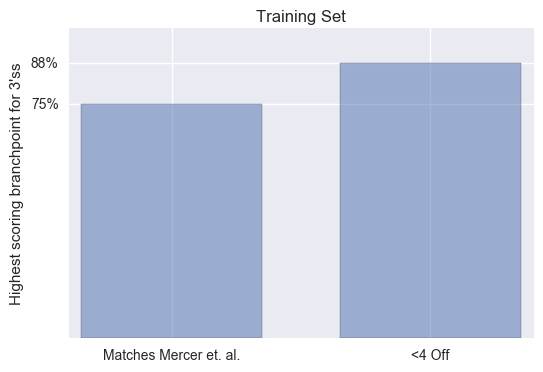

(19402, 3409, 25711)


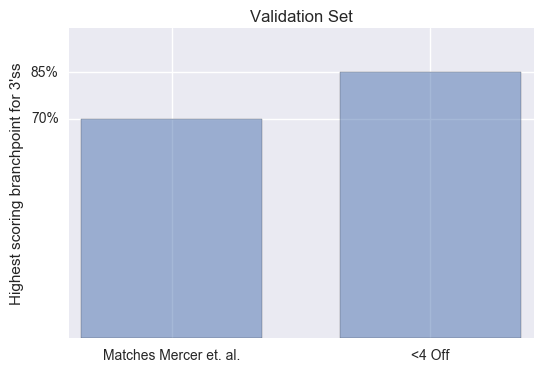

(5028, 1056, 7093)


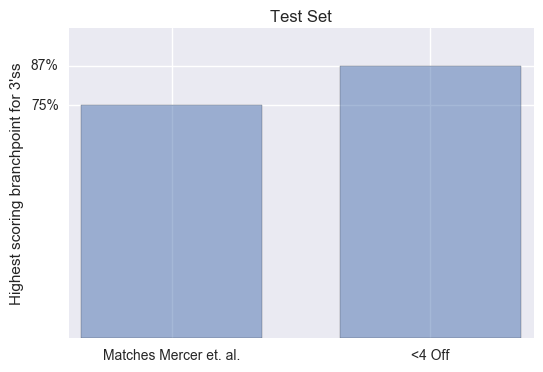

(3234, 554, 4306)


In [29]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, shifted = 0, 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        elif any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-E, np.argmax(p)+B+1)):
            shifted += 1
        total += 1
    heights = [match / float(total), (match+shifted) / float(total)]
    index = [0, .5]
    plt.bar(index, heights, .35, align = 'center', alpha = 0.5)
    plt.ylim(0, 1)
    plt.xticks(index, ['Matches Mercer et. al.', '<4 Off'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return match, shifted, total

print shifted_matching(model.predict(X_train[:, :, :4]), y_train, 'Training Set')
print shifted_matching(model.predict(X_valid[:, :, :4]), y_valid, 'Validation Set')
print shifted_matching(model.predict(X_test[:, :, :4]),  y_test, 'Test Set')   

# TPR at FDR x

In [30]:
test_preds = model.predict(X_test[:, :, :4])

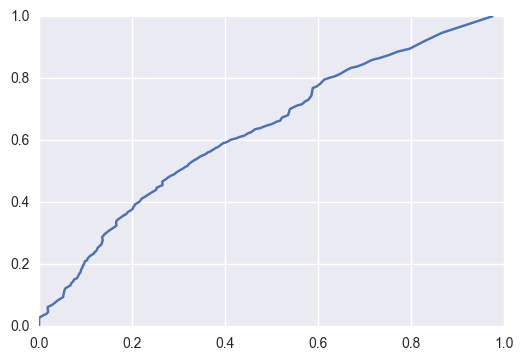

In [31]:
# (number neg above threshold) / (total above threshold)

def tpr_fdr_curve(preds, y, samples = 200):
    tpr, fdr = [], []
    thresholds = np.linspace(preds.min(), preds.max(), samples)
    for threshold in thresholds:
        tp = np.sum((preds > threshold) & (y == 1))
        fp = np.sum((preds > threshold) & (y == 0))
        pos = np.sum(y == 1)
        
        tpr += [tp / float(pos)]
        fdr += [fp / float(fp + tp)]
    return np.array(fdr), np.array(tpr), thresholds

fdr, tpr, thresh = tpr_fdr_curve(test_preds, y_test.reshape(-1, 70, 1))
plt.plot(fdr, tpr)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

# Examples

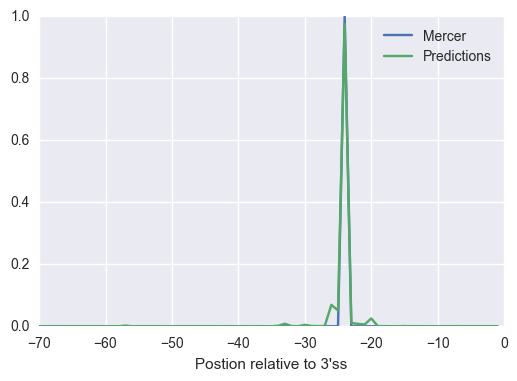

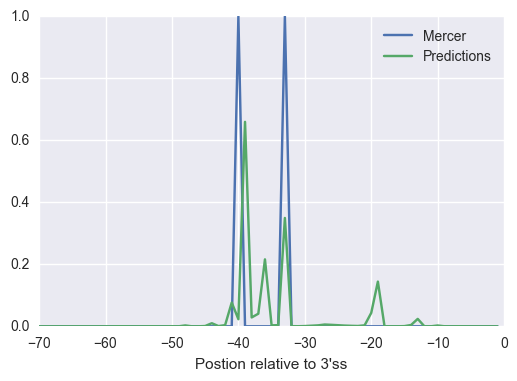

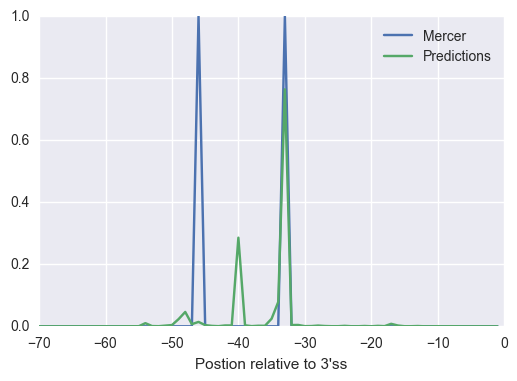

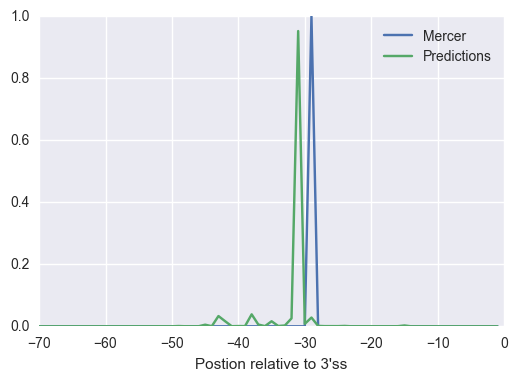

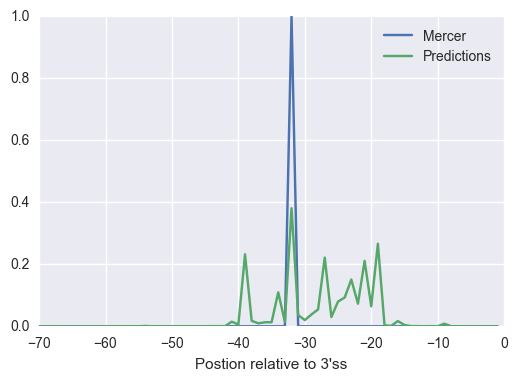

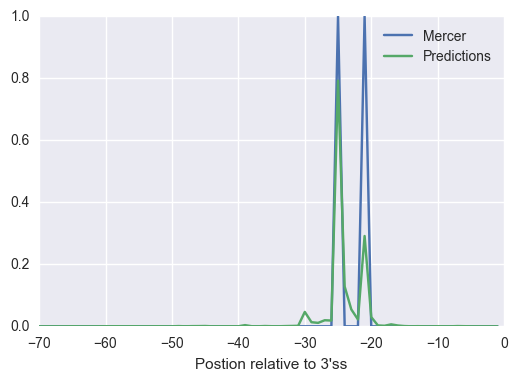

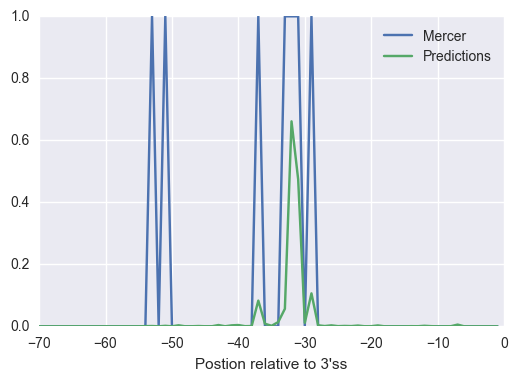

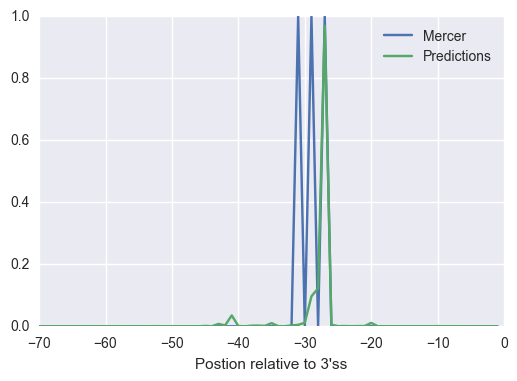

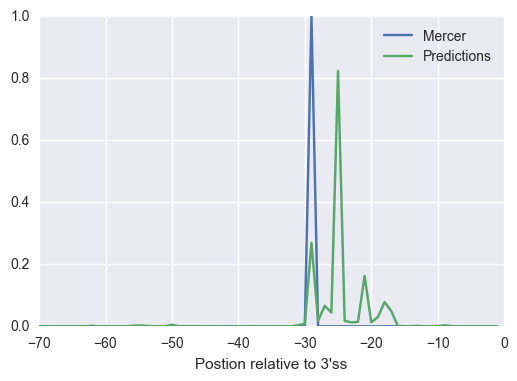

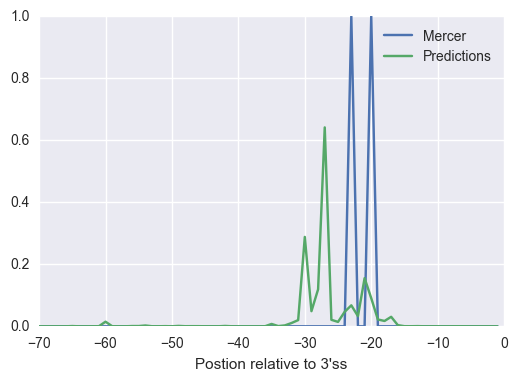

In [32]:
plot_examples(test_preds, y_test)

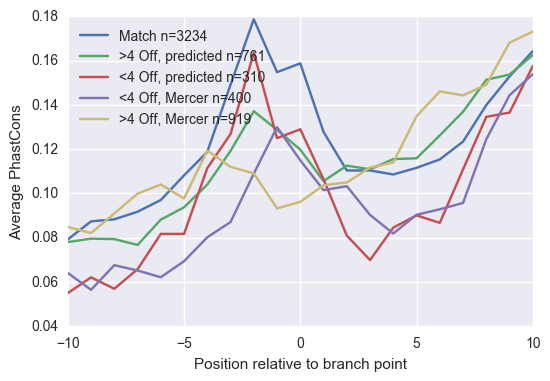

In [33]:
K = 10

B, E = -4, 0

# Correctly Predicted
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if np.argmax(target) not in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "Match n={}".format(total))

# Incorrect, use predicted BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = ">4 Off, predicted n={}".format(total))

# Incorrect, use predicted BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if not any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "<4 Off, predicted n={}".format(total))

# < use Mercer BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if not any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    
    for bp in np.nonzero(truth)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
    
plt.plot(range(-K, K+1), counts / total,
         label = "<4 Off, Mercer n={}".format(total))

# >4 off, use Mercer
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    
    for bp in np.nonzero(truth)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total,
         label = ">4 Off, Mercer n={}".format(total))

plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.legend(loc = 'best')
plt.show()

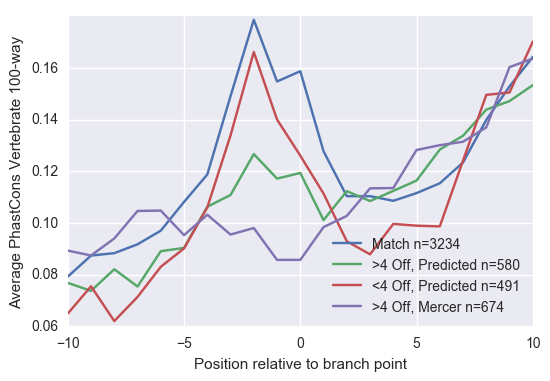

In [34]:
K = 10
B, E = -4, 4

# Correctly Predicted
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if np.argmax(target) not in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "Match n={}".format(total))

# Incorrect, use predicted BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = ">4 Off, Predicted n={}".format(total))

# Incorrect, use predicted BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if not any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "<4 Off, Predicted n={}".format(total))

# >4 off, use Mercer
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(truth)[0] for i in range(np.argmax(target)+B, np.argmax(target)+E)): continue
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    
    for bp in np.nonzero(truth)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total,
         label = ">4 Off, Mercer n={}".format(total))

plt.ylabel('Average PhastCons Vertebrate 100-way')
plt.xlabel('Position relative to branch point')
plt.legend(loc = 'best')
plt.show()

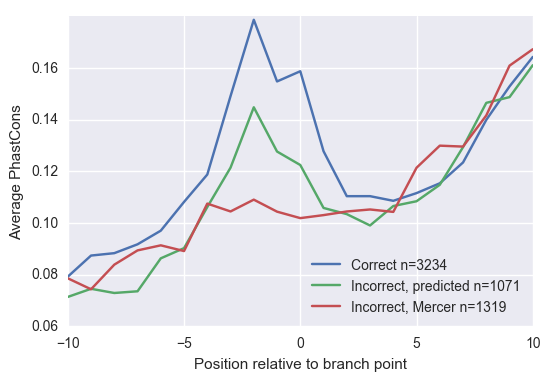

In [35]:
K = 10

# Correctly Predicted
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if np.argmax(target) not in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "Correct n={}".format(total))

# Incorrect, use predicted BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(range(-K, K+1), counts / total,
         label = "Incorrect, predicted n={}".format(total))

# Incorrect use Mercer BP
counts = np.zeros((2*K+1,))
total = 0
for target, truth, seq in zip(test_preds, y_test, X_test):
    if np.argmax(target) in np.nonzero(truth)[0]: continue
    for bp in np.nonzero(truth)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
    
plt.plot(range(-K, K+1), counts / total,
         label = "Incorrect, Mercer n={}".format(total))

plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.legend(loc = 'best')
plt.show()

[20, 23, 24, 39, 50, 56, 80, 39, 87, 116, 3234, 74, 60, 69, 76, 64, 62, 30, 37, 27]


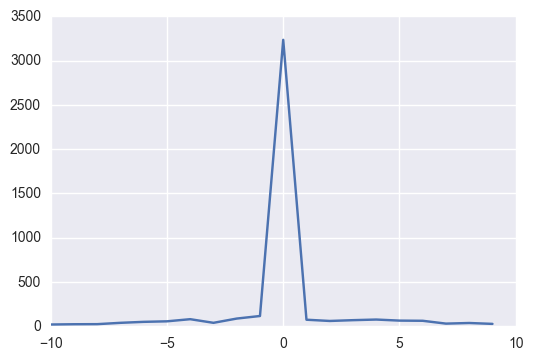

In [36]:
def shift(preds, y):
    match = []
    for offset in range(-10, 10):
        match += [0]
        for p, t in zip(preds, y):
            if offset != 0 and np.argmax(p) in np.nonzero(t)[0]: continue
            if np.argmax(p)+offset in np.nonzero(t)[0]:
                match[-1] += 1
    print match
    plt.plot(range(-10, 10), match)
    plt.show()

shift(test_preds, y_test)

20


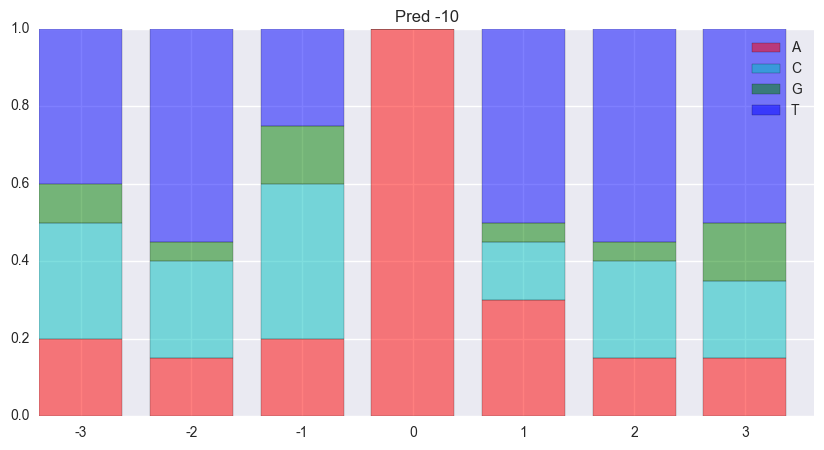

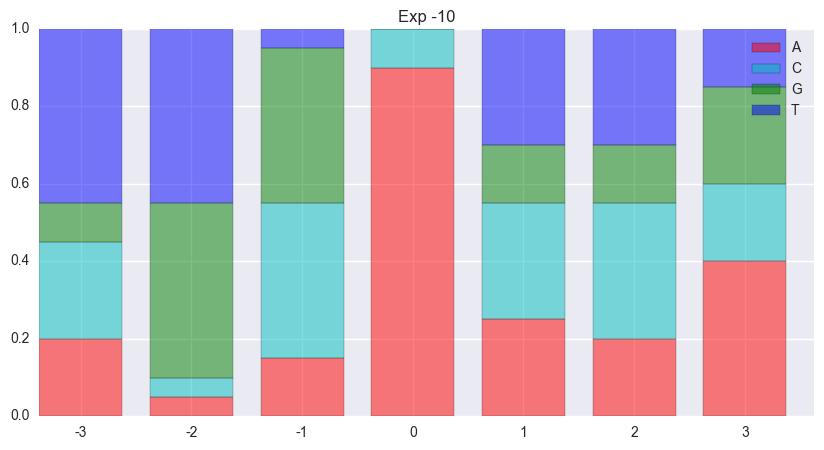

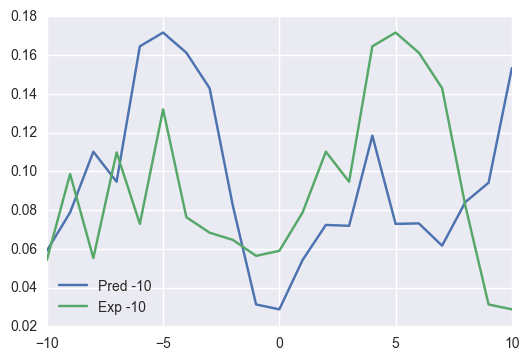

23


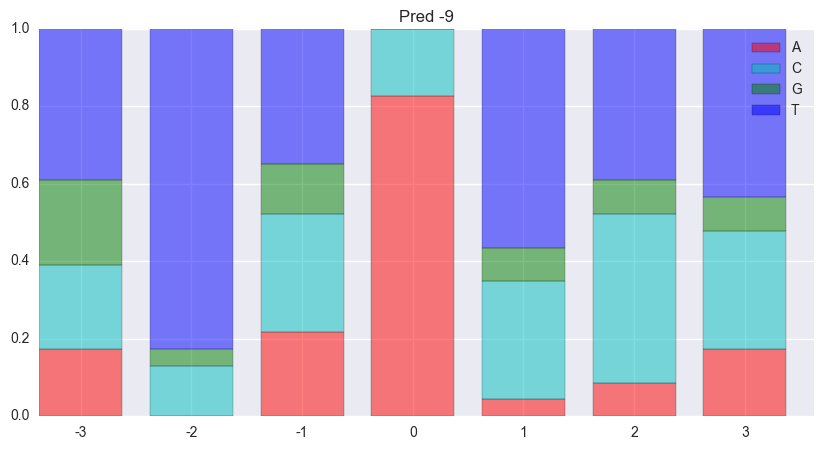

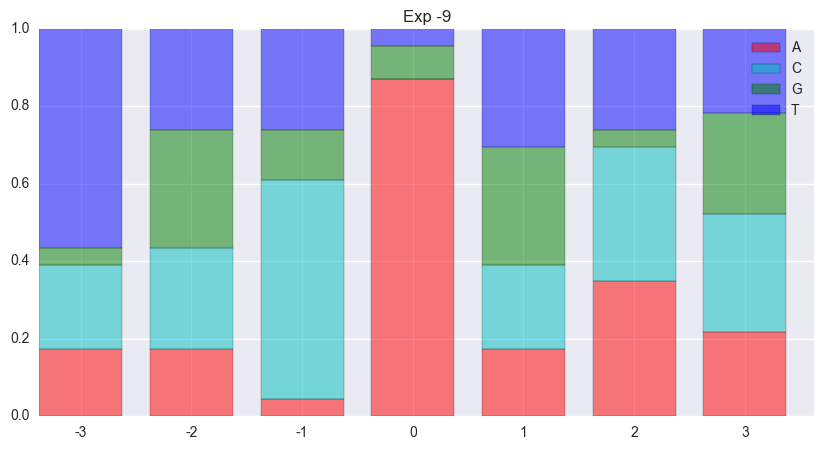

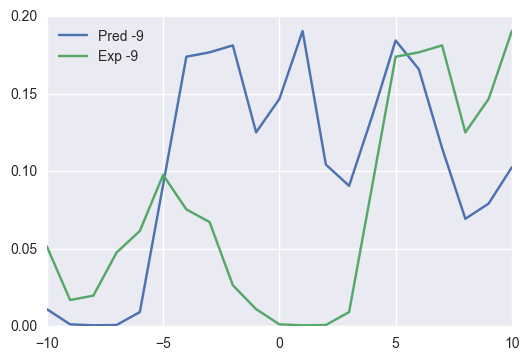

24


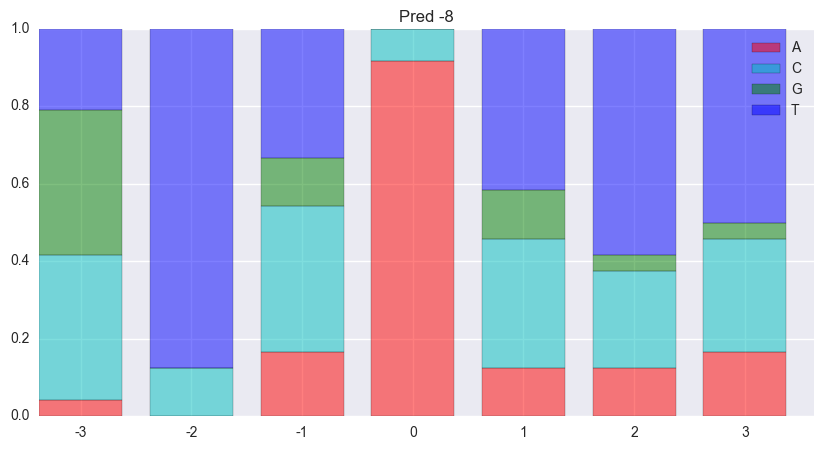

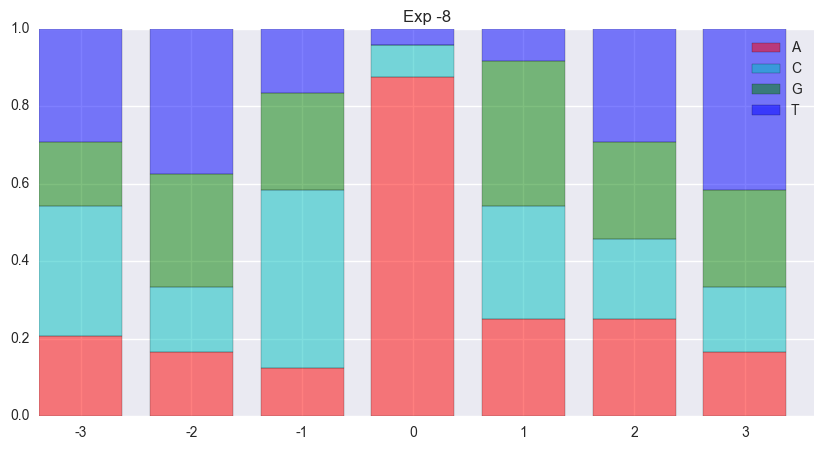

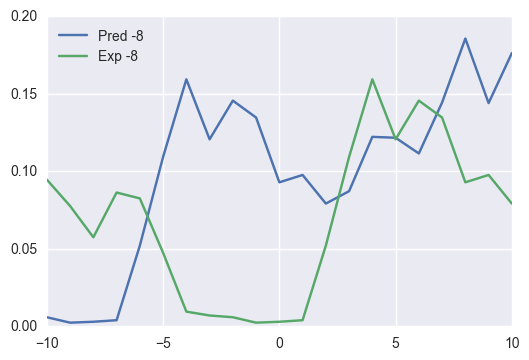

39


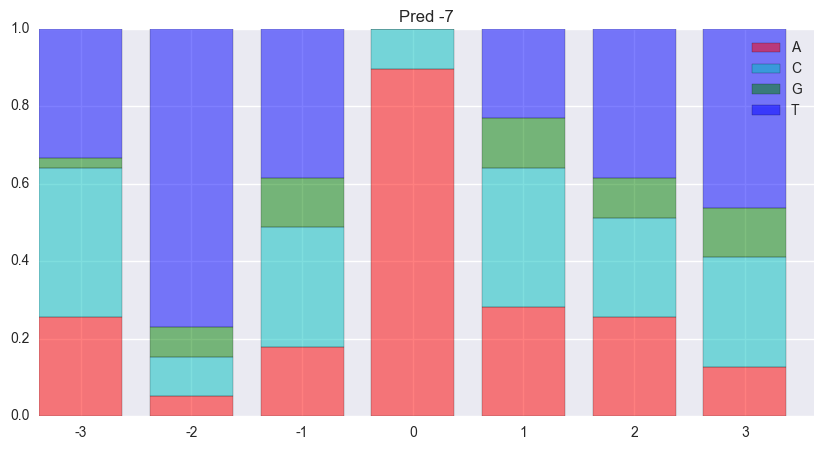

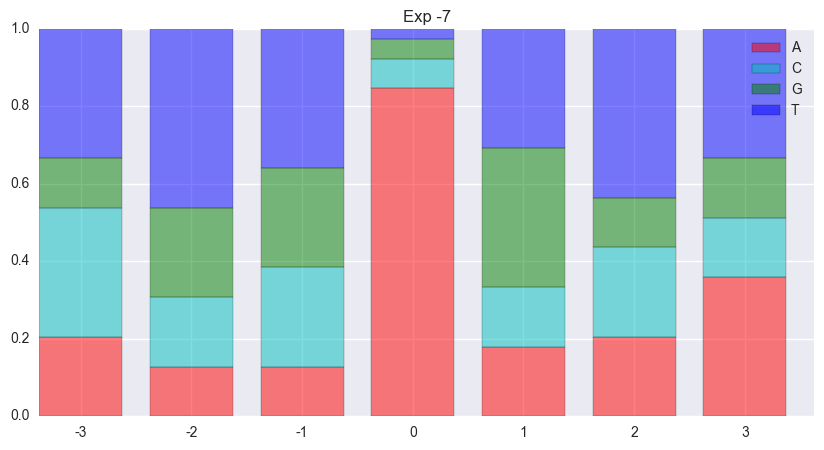

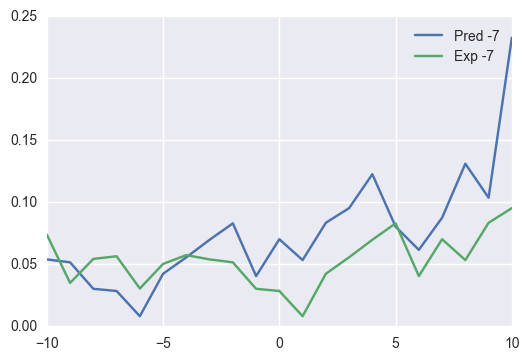

50


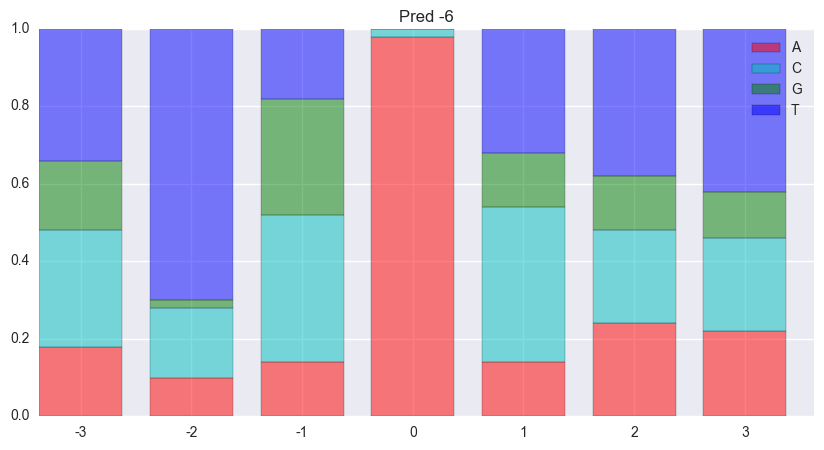

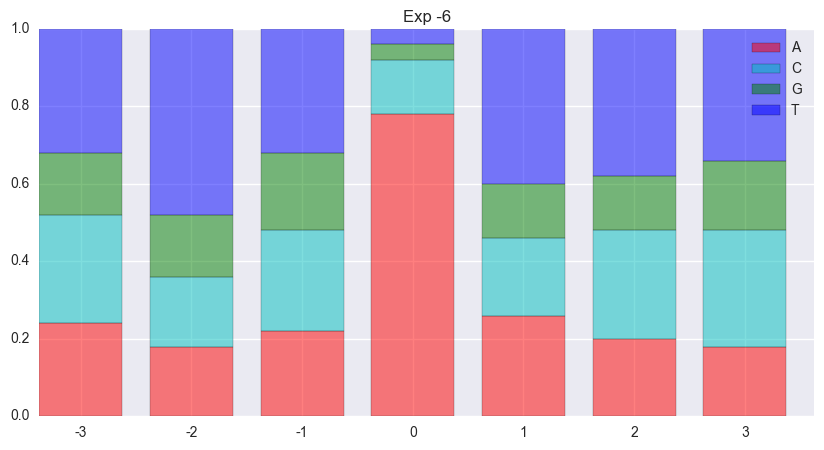

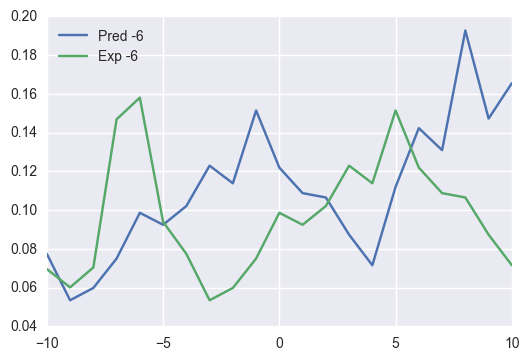

56


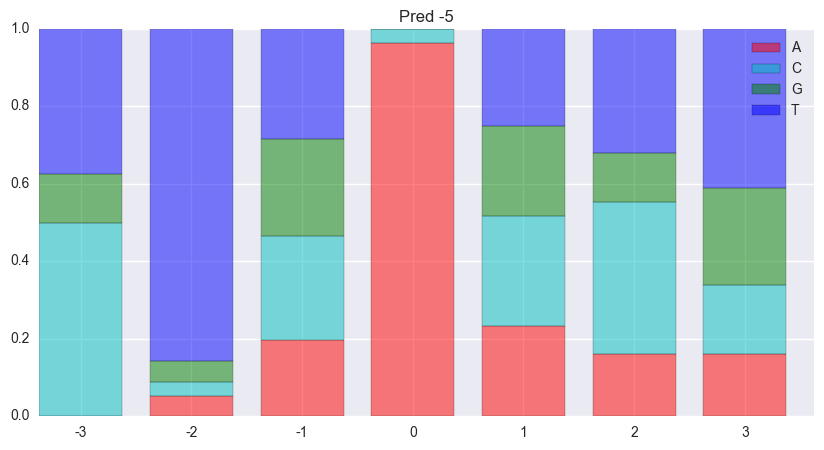

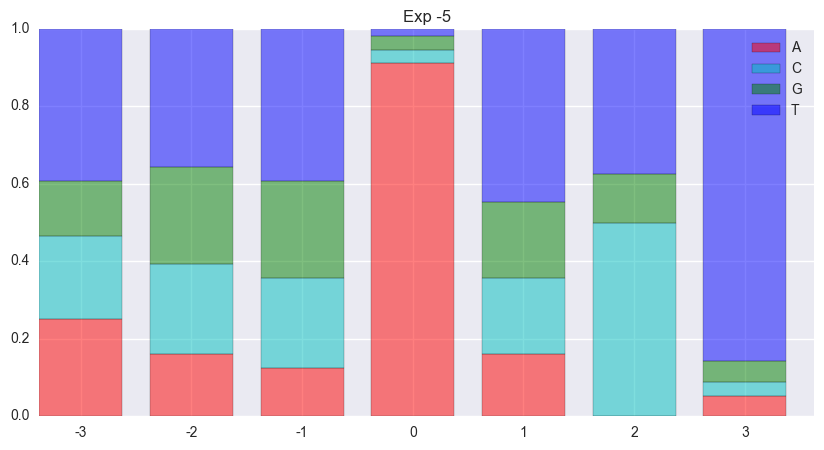

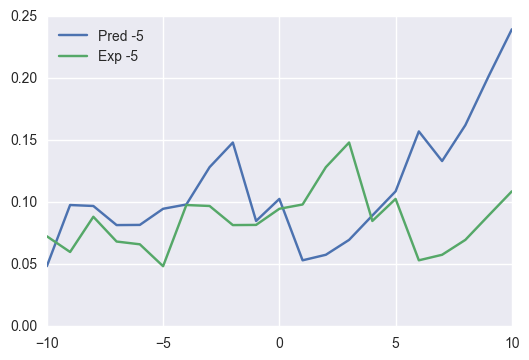

80


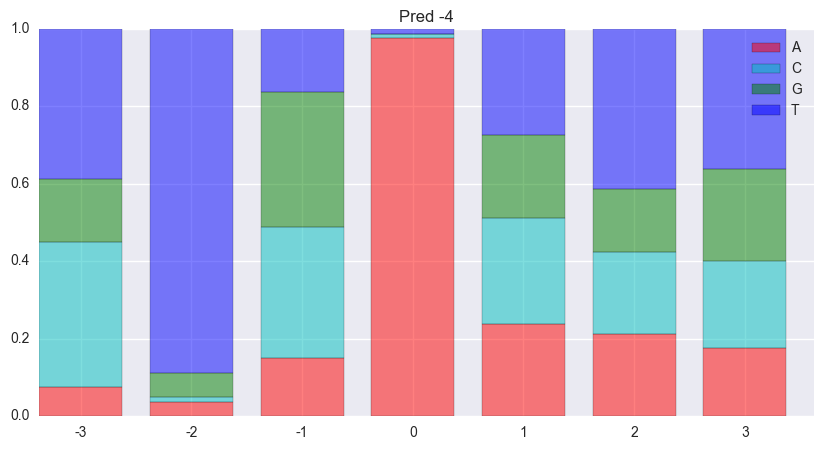

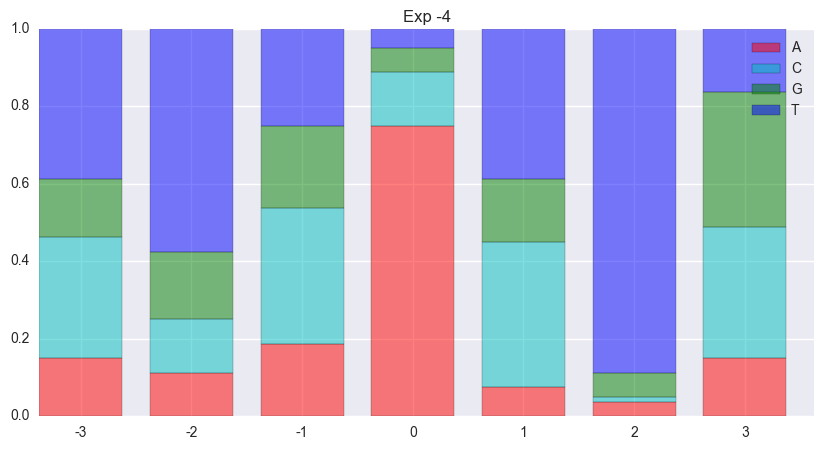

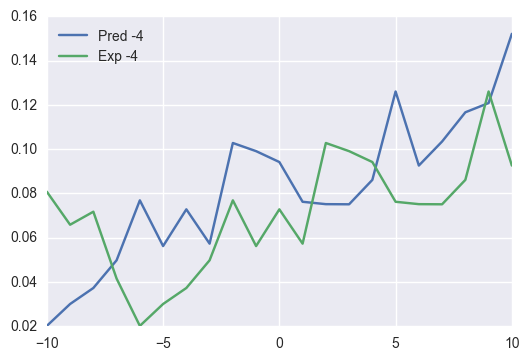

39


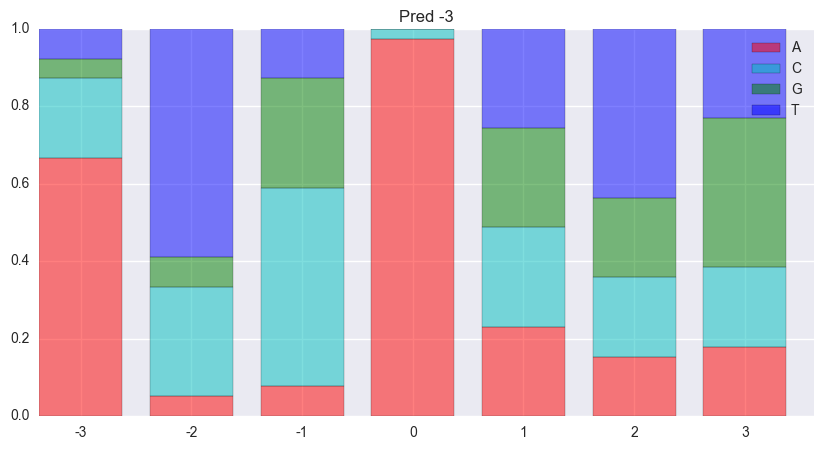

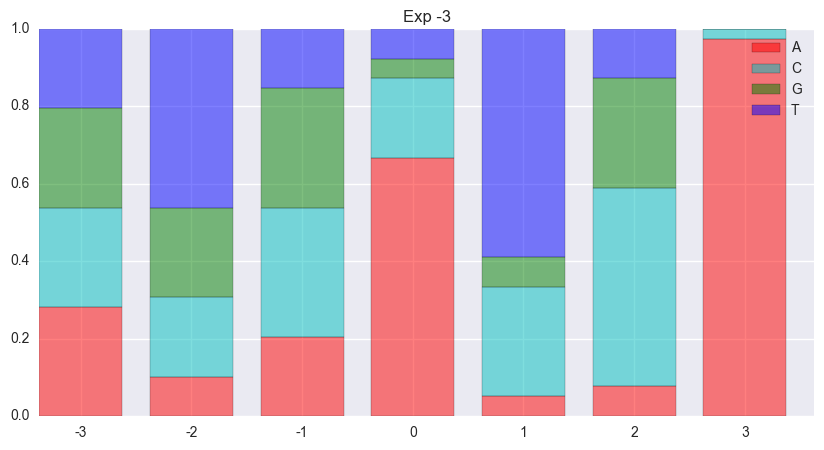

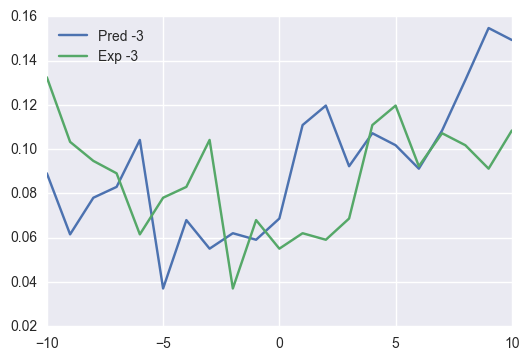

87


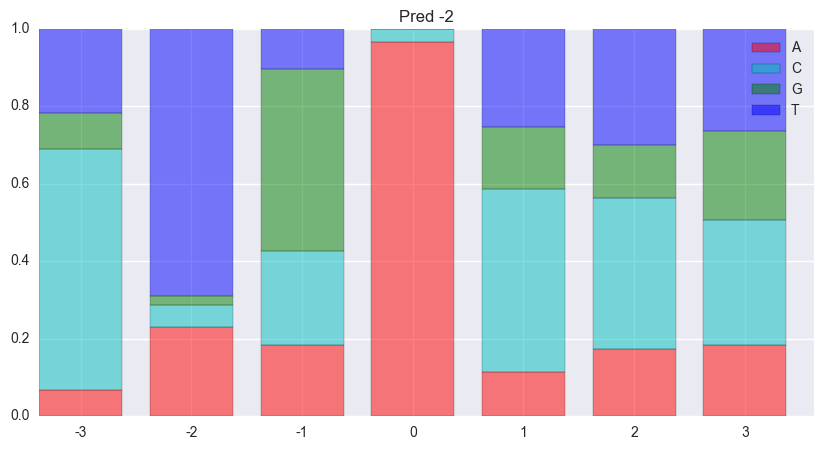

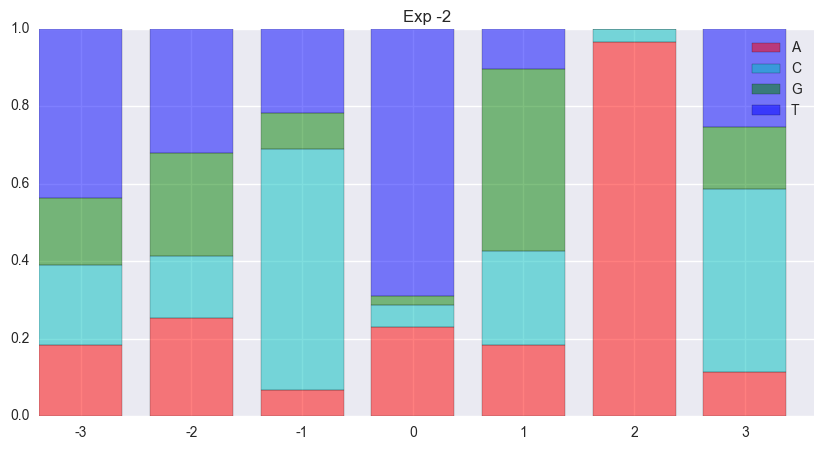

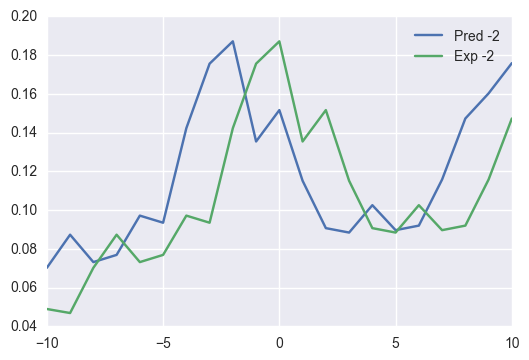

115


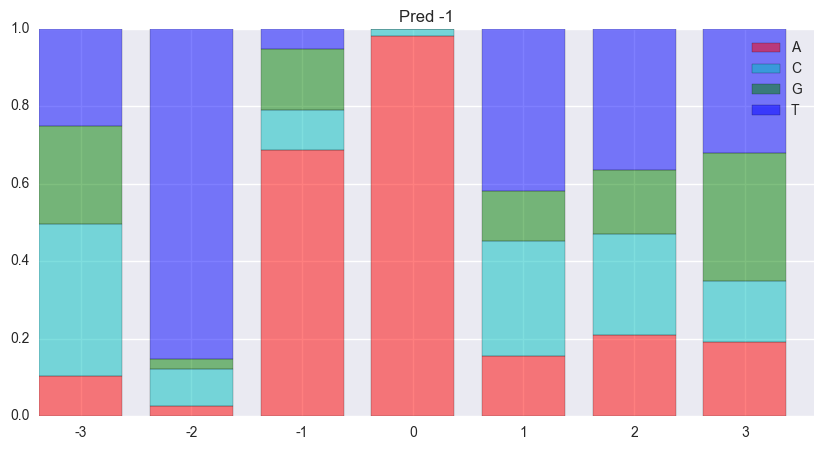

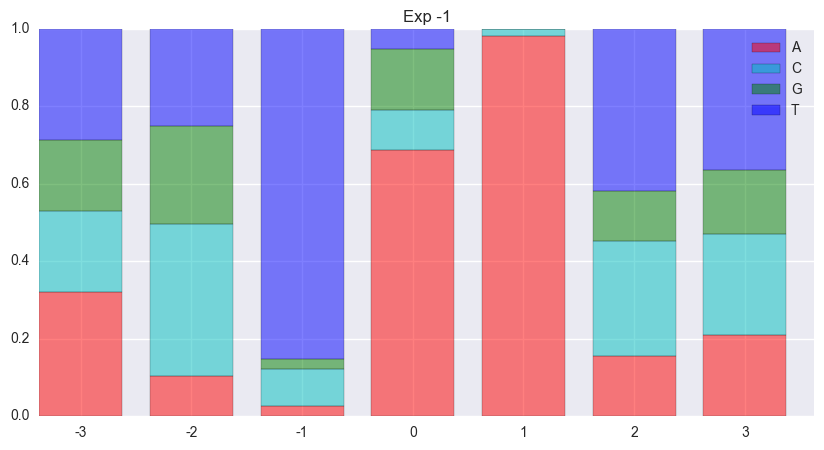

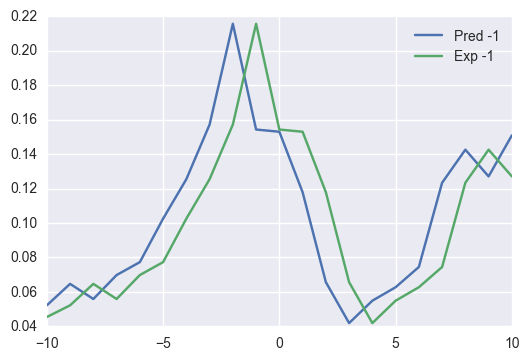

0


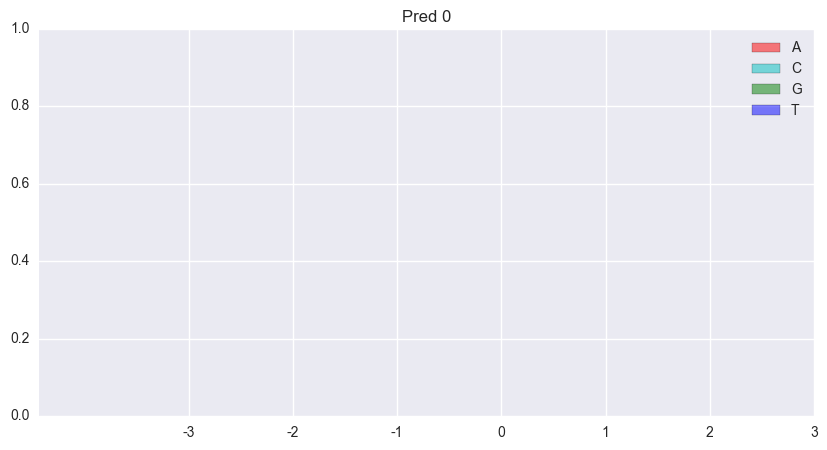

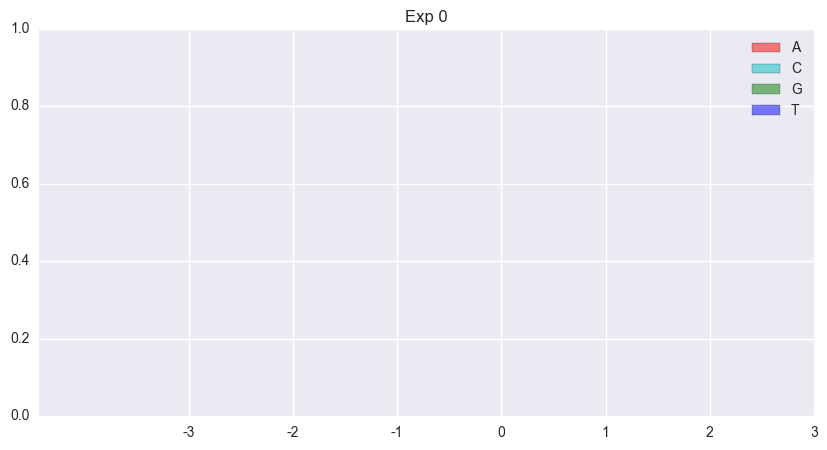

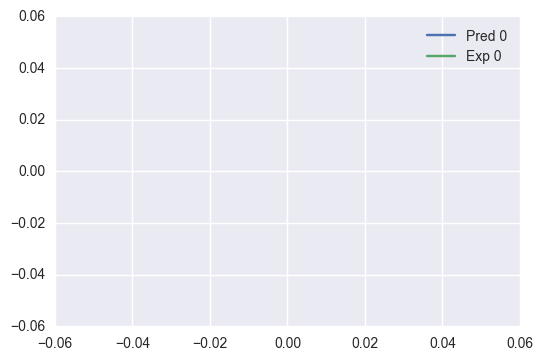

74


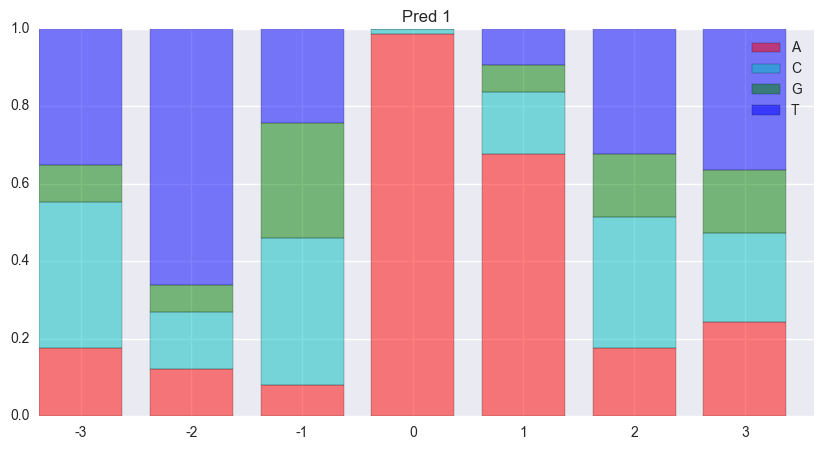

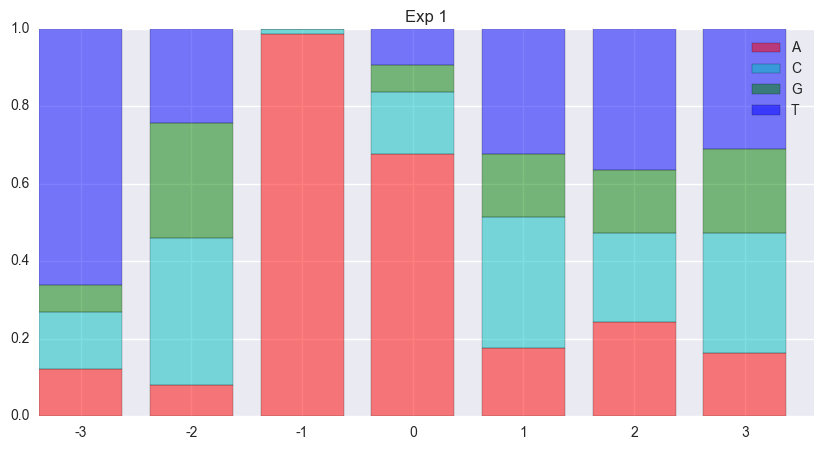

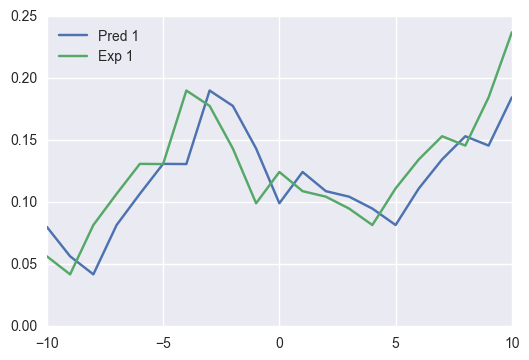

60


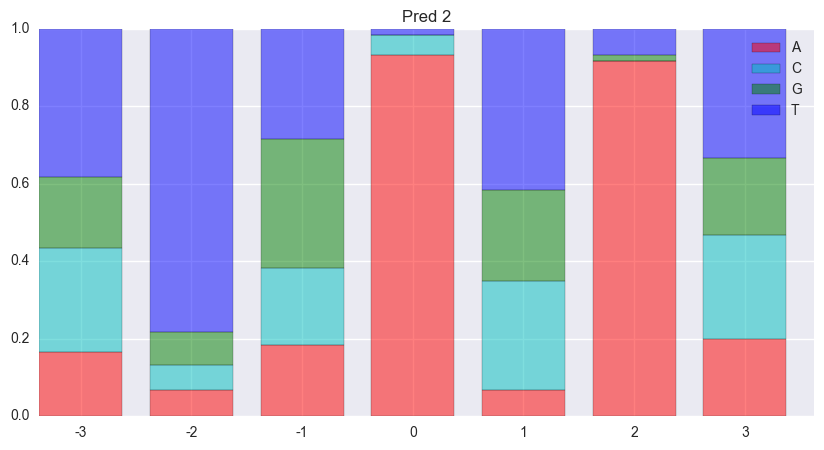

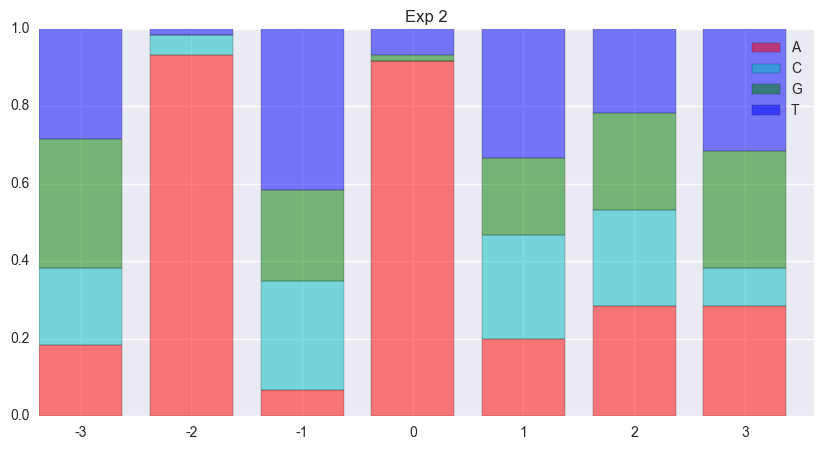

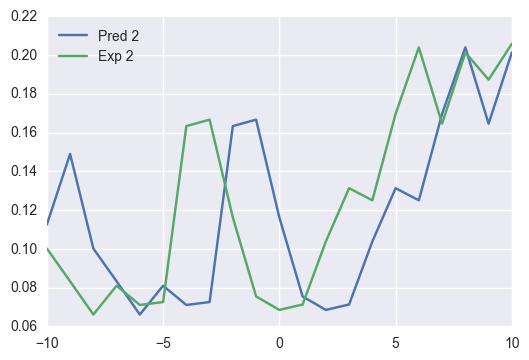

69


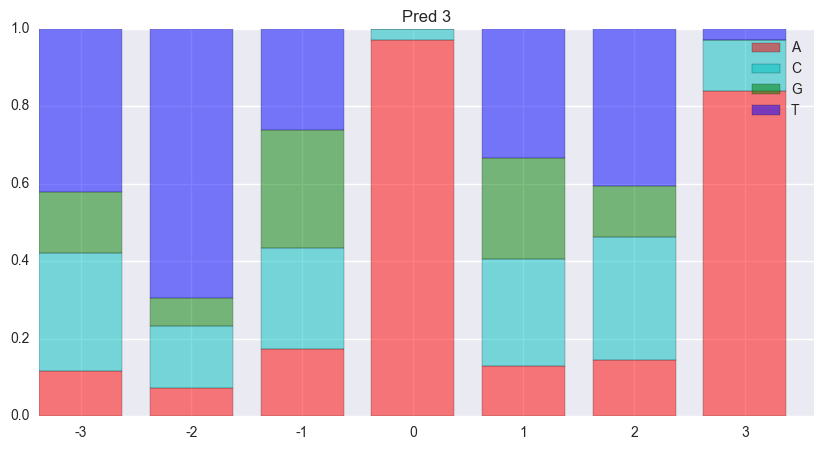

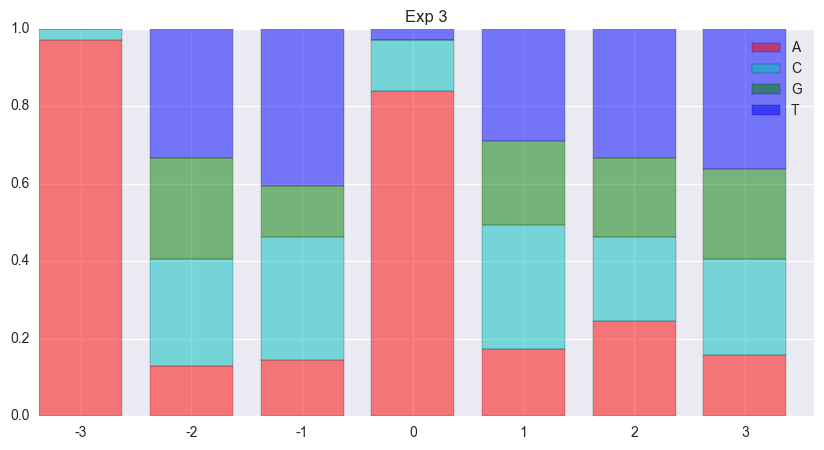

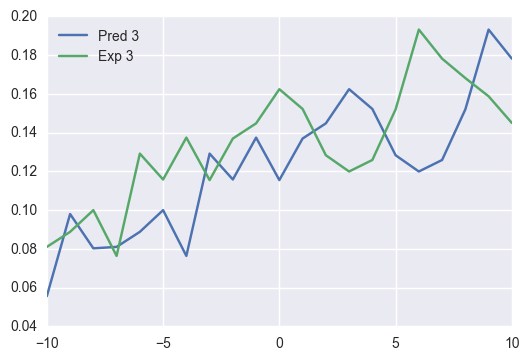

76


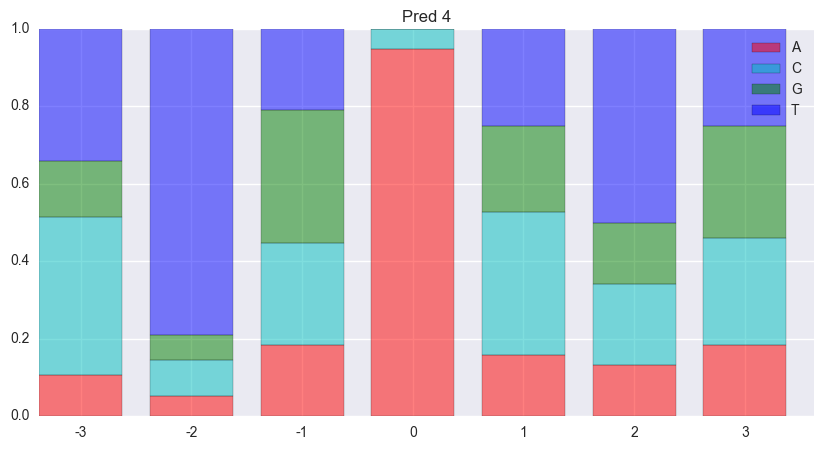

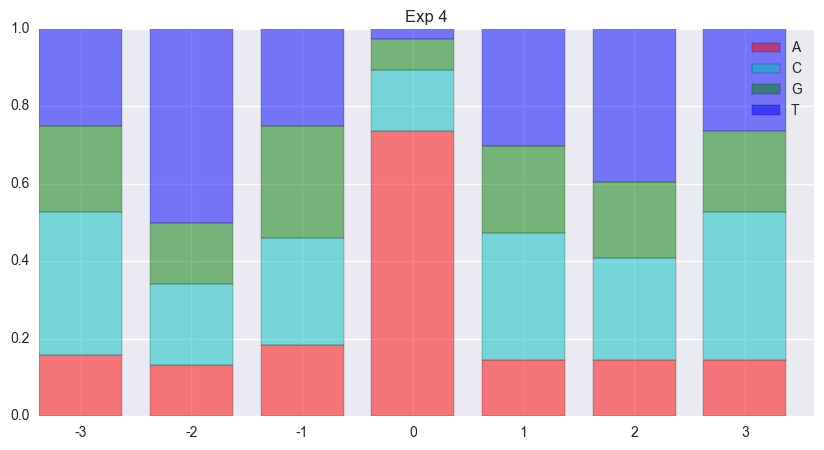

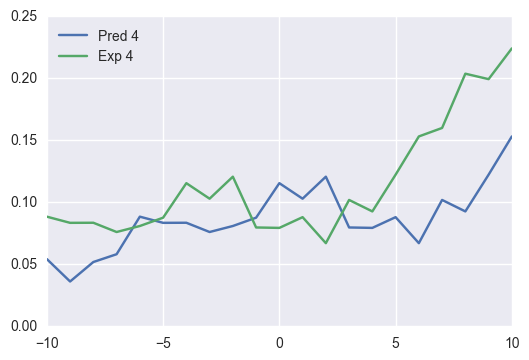

64


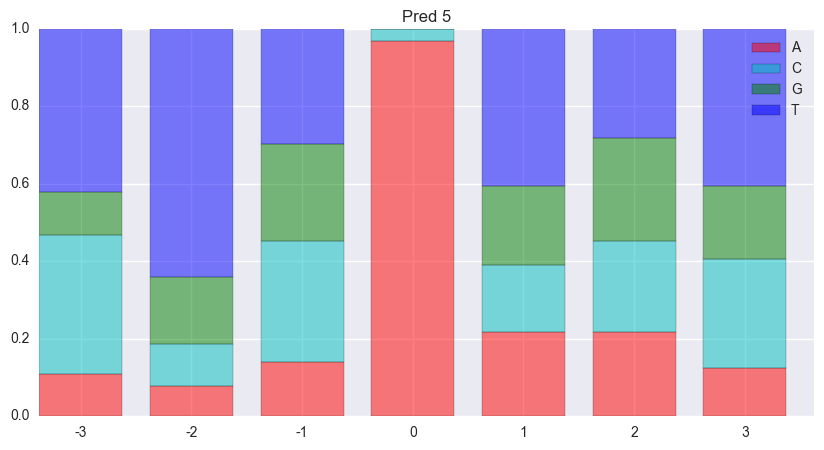

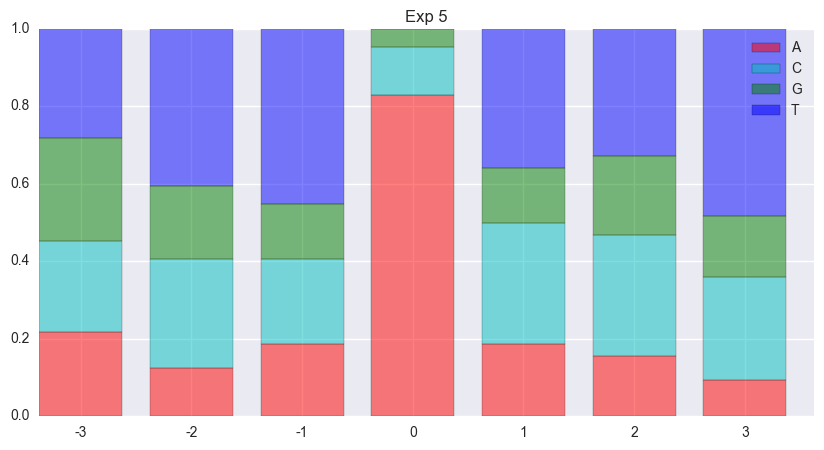

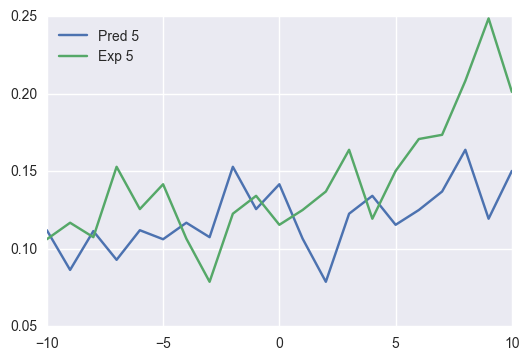

62


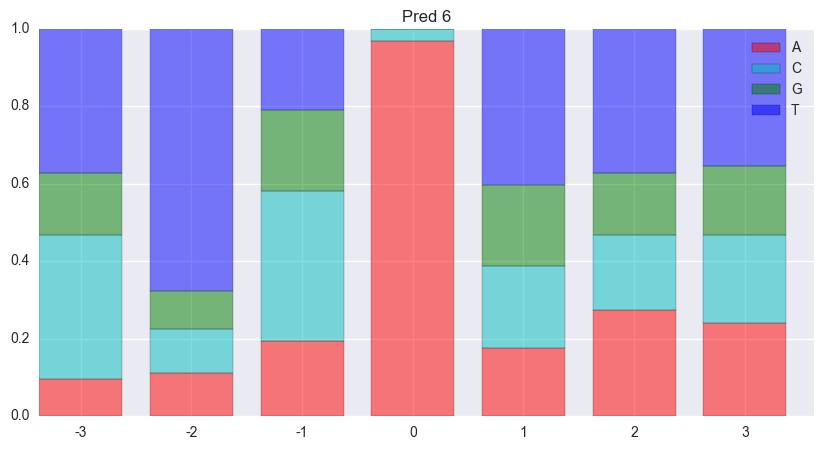

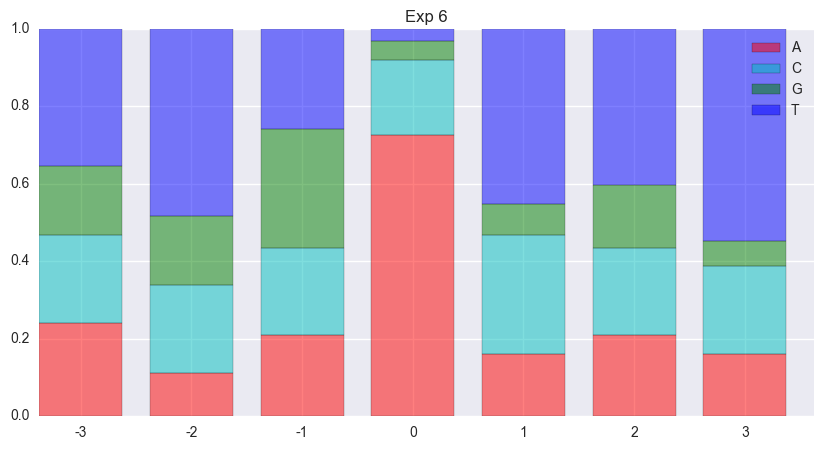

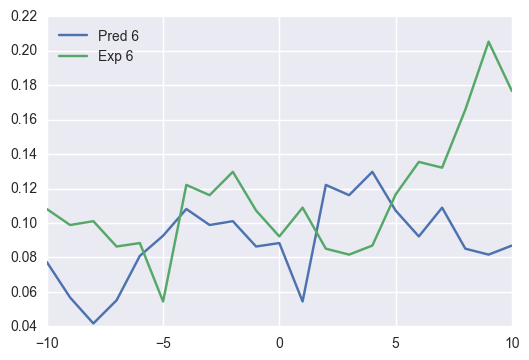

30


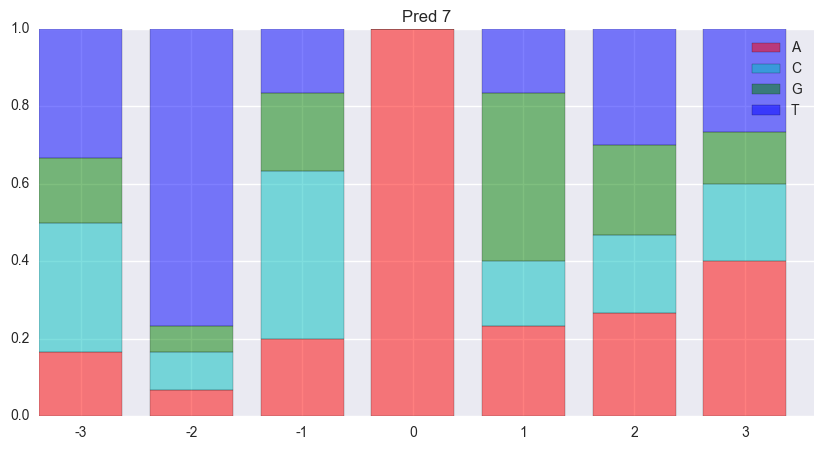

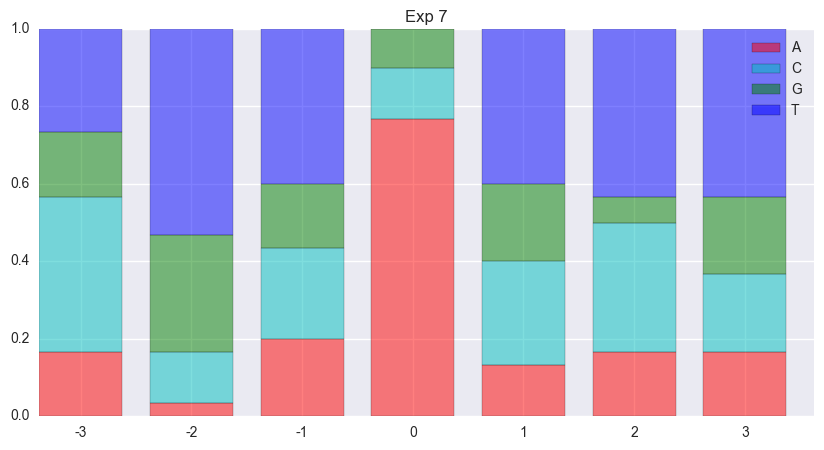

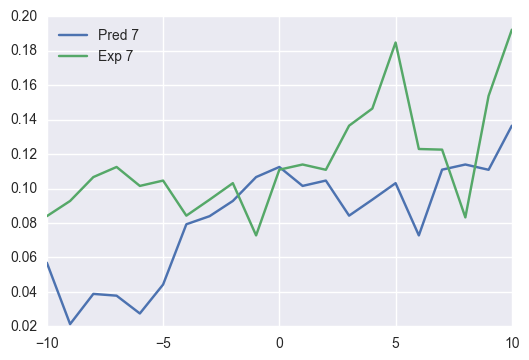

37


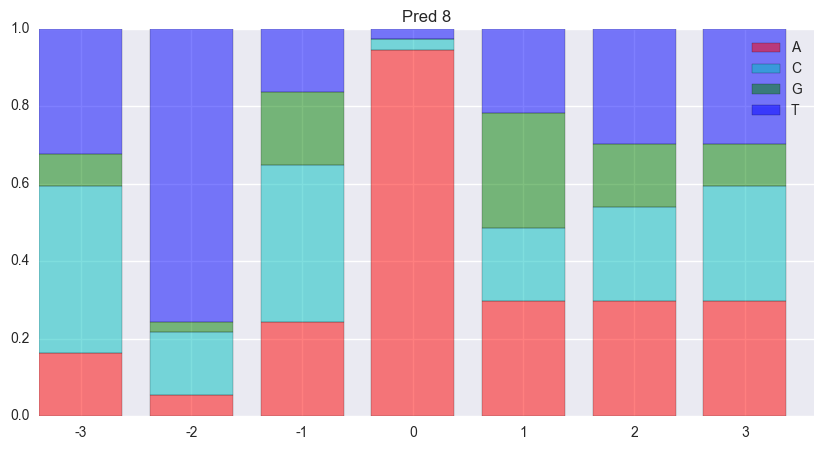

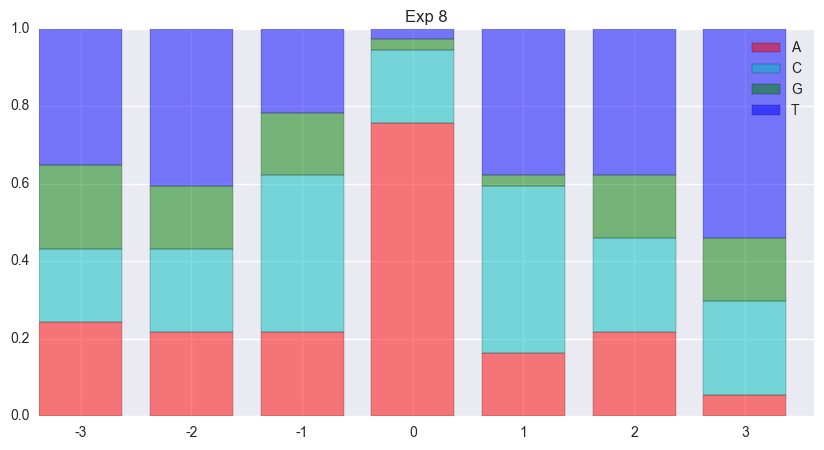

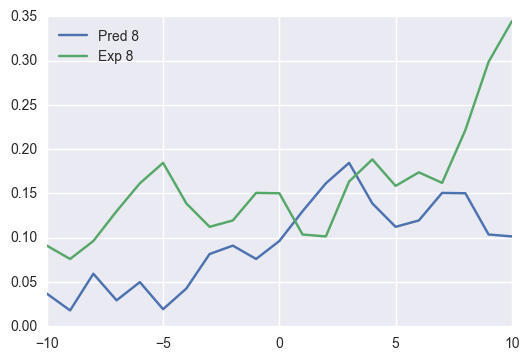

27


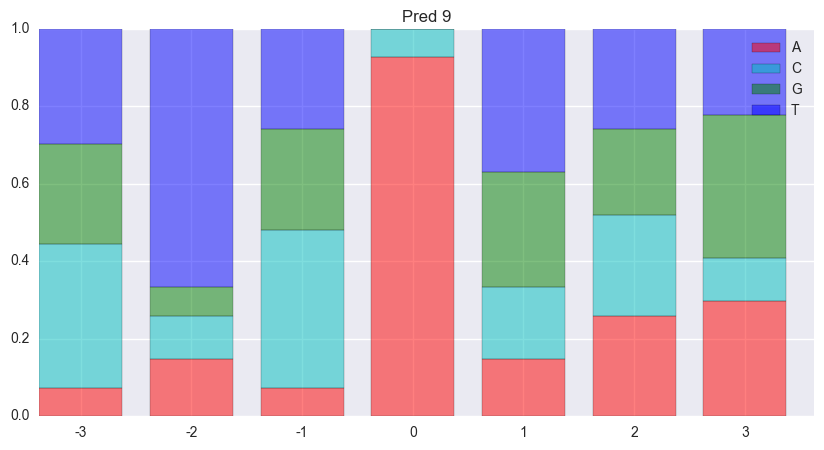

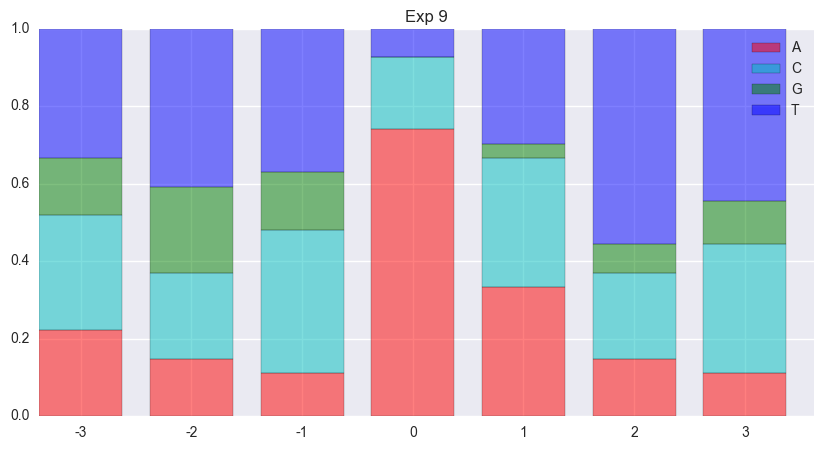

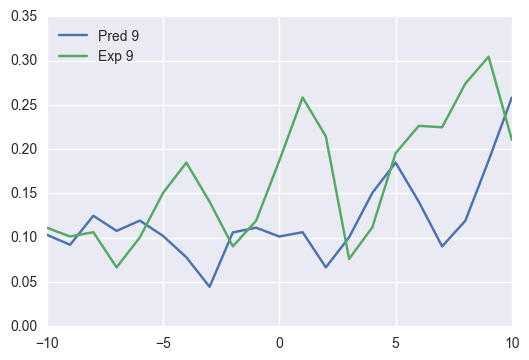

In [37]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
for offset in range(-10, 10):
    counts1 = np.zeros((2*K+1, 4))
    counts2 = np.zeros((2*K+1, 4))
    cons1 = np.zeros((2*C+1,))
    cons2 = np.zeros((2*C+1,))
    total = 0
    for p, t, seq in zip(test_preds, y_test, X_test):
        if np.argmax(p) in np.nonzero(t)[0]: continue
        if np.argmax(p)+offset in np.nonzero(t)[0]:
            bp = np.argmax(p)
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts1 = counts1 + seq[bp-K: bp+K+1, :4]
            cons1 = cons1 + seq[bp-C:bp+C+1, 4]
            
            bp = np.argmax(p)+offset
            if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
            counts2 = counts2 + seq[bp-K: bp+K+1, :4]
            cons2 = cons2 + seq[bp-C:bp+C+1, 4]
            
            total += 1
    print total
    pwm_logo(counts1 / total, "Pred {}".format(offset))
    pwm_logo(counts2 / total, "Exp {}".format(offset))
    plt.plot(range(-C, C+1), cons1 / total, label = "Pred {}".format(offset))
    plt.plot(range(-C, C+1), cons2 / total, label = "Exp {}".format(offset))
    plt.legend(loc = 'best')
    plt.show()

227
510


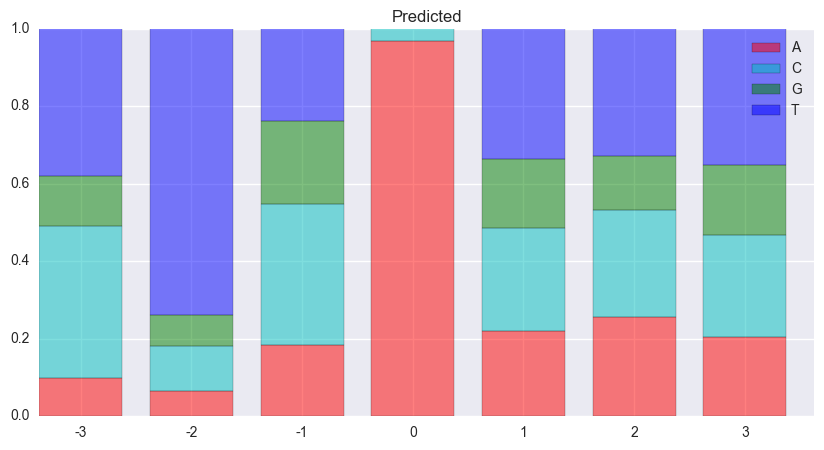

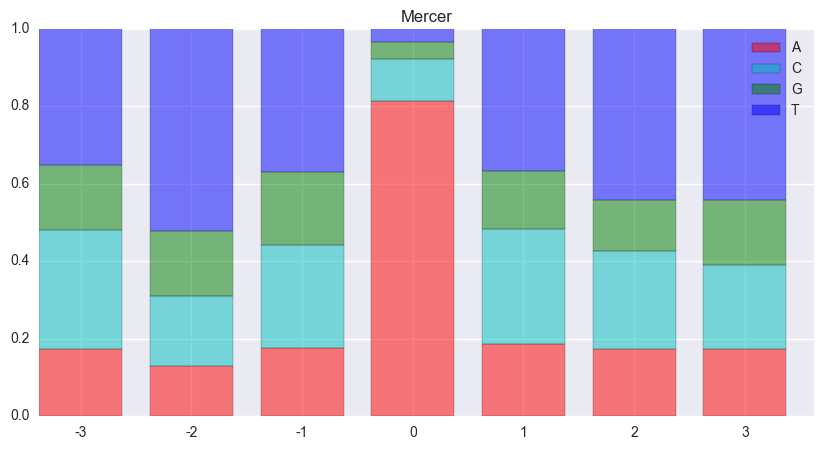

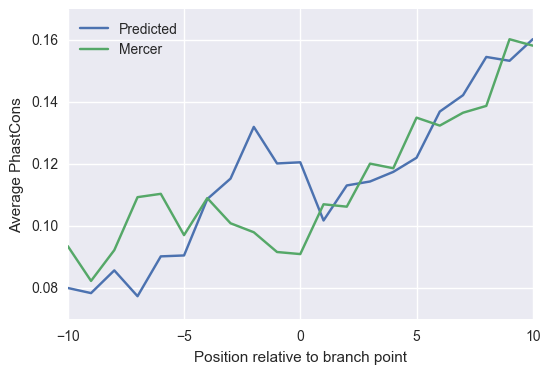

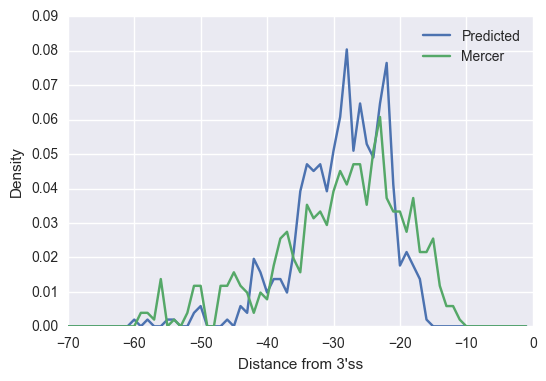

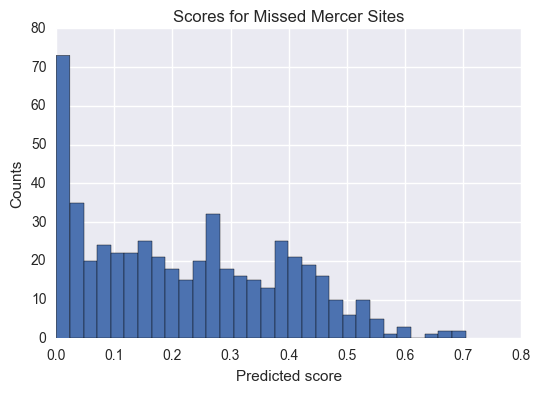

In [38]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
scores = []
second = 0
total = 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts2 = counts2 + seq[bp-K: bp+K+1, :4]
    cons2 = cons2 + seq[bp-C:bp+C+1, 4]
    dist2[bp] += 1
    
    
    scores += [p[bp, 0]]
    second += sum(scores[-1] < p.flatten()) == 1

    total += 1
print second
print total
pwm_logo(counts1 / total, "Predicted")
pwm_logo(counts2 / total, "Mercer")
plt.plot(range(-C, C+1), cons1 / total, label = "Predicted")
plt.plot(range(-C, C+1), cons2 / total, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.show()

plt.plot(range(-70, 0), dist1 / total, label = "Predicted")
plt.plot(range(-70, 0), dist2 / total, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Density')
plt.xlabel("Distance from 3'ss")
plt.show()

plt.hist(scores, bins = 30)
plt.title('Scores for Missed Mercer Sites')
plt.ylabel('Counts')
plt.xlabel('Predicted score')
plt.show()

227
510


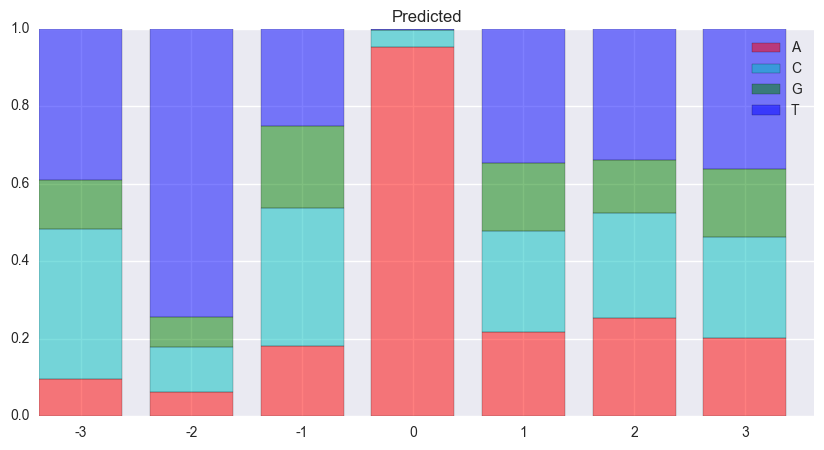

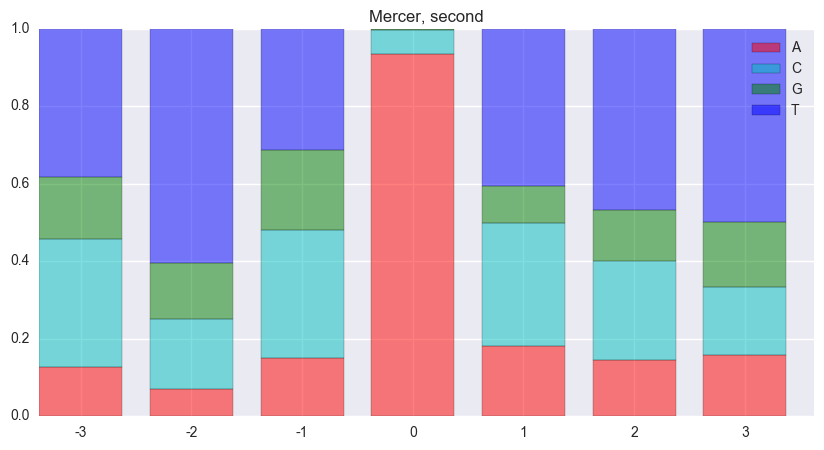

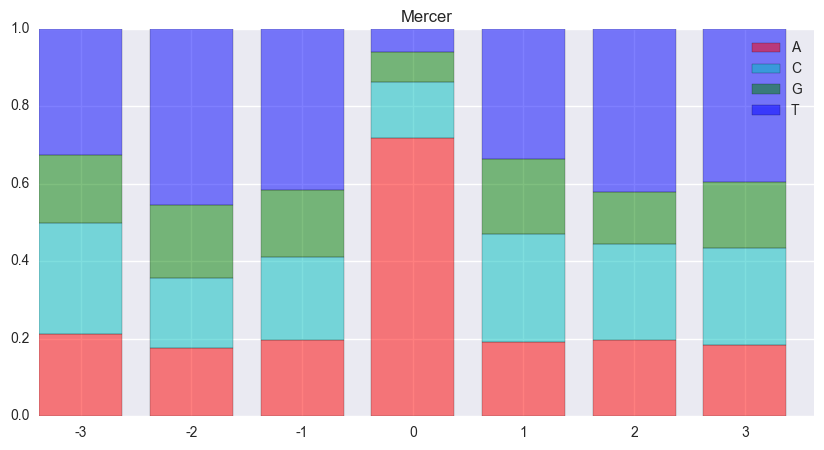

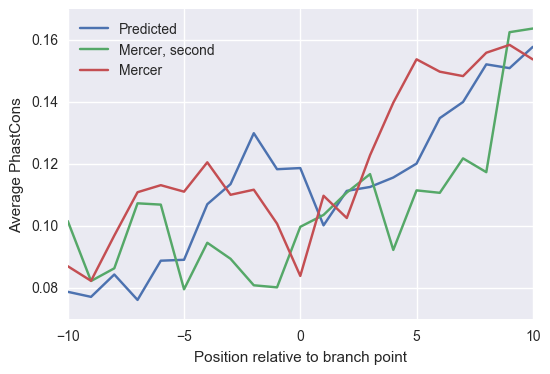

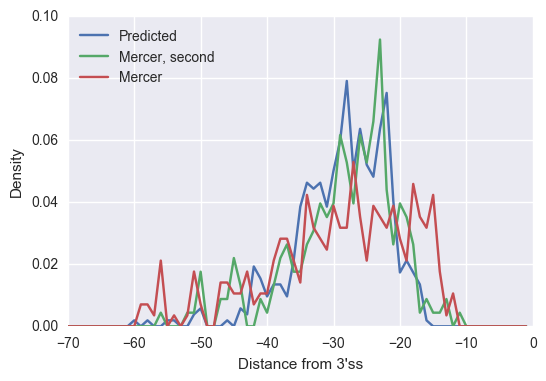

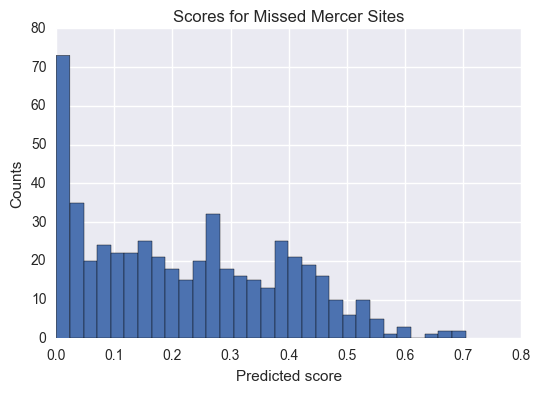

In [39]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
counts3 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
cons3 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
dist3 = np.zeros((L,))
scores = []
second = 0
total1, total2, total3 = 0, 0, 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1
    total1 += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    
    scores += [p[bp, 0]]
    second += sum(scores[-1] < p.flatten()) == 1
        
    if sum(scores[-1] < p.flatten()) == 1:
        counts2 = counts2 + seq[bp-K: bp+K+1, :4]
        cons2 = cons2 + seq[bp-C:bp+C+1, 4]
        dist2[bp] += 1
        total2 += 1
    else:
        counts3 = counts3 + seq[bp-K: bp+K+1, :4]
        cons3 = cons3 + seq[bp-C:bp+C+1, 4]
        dist3[bp] += 1
        total3 += 1

    
print second
print total
pwm_logo(counts1 / total1, "Predicted")
pwm_logo(counts2 / total2, "Mercer, second")
pwm_logo(counts3 / total3, "Mercer")


plt.plot(range(-C, C+1), cons1 / total1, label = "Predicted")
plt.plot(range(-C, C+1), cons2 / total2, label = "Mercer, second")
plt.plot(range(-C, C+1), cons3 / total3, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Average PhastCons')
plt.xlabel('Position relative to branch point')
plt.show()

plt.plot(range(-70, 0), dist1 / total1, label = "Predicted")
plt.plot(range(-70, 0), dist2 / total2, label = "Mercer, second")
plt.plot(range(-70, 0), dist3 / total3, label = "Mercer")
plt.legend(loc = 'best')
plt.ylabel('Density')
plt.xlabel("Distance from 3'ss")
plt.show()

plt.hist(scores, bins = 30)
plt.title('Scores for Missed Mercer Sites')
plt.ylabel('Counts')
plt.xlabel('Predicted score')
plt.show()

553


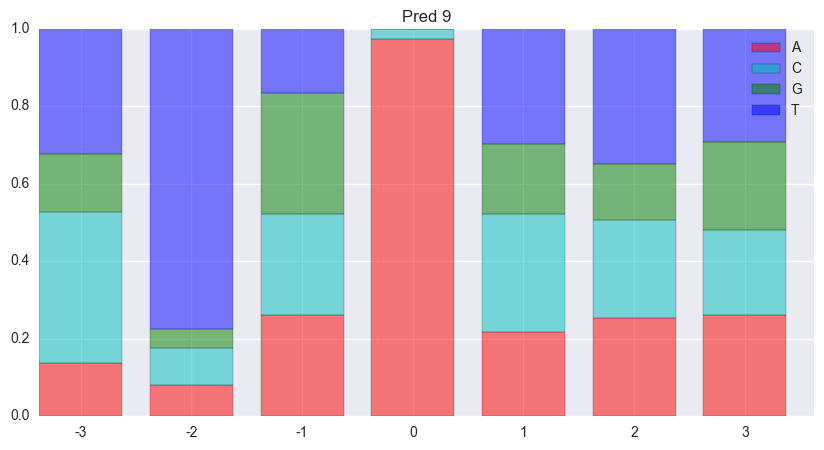

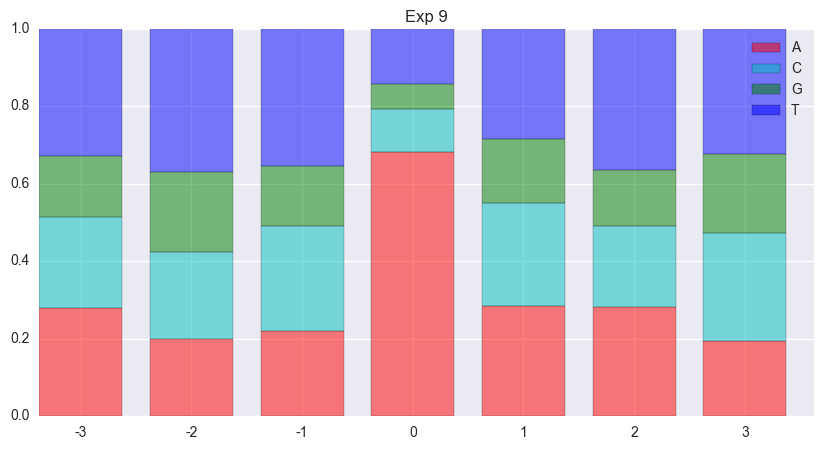

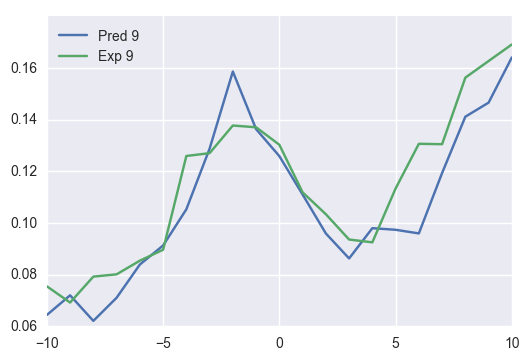

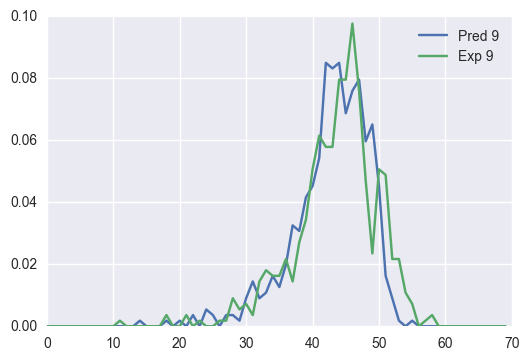

In [40]:
# For each shift, build a pwm centered on prediction
K, C = 3, 10
counts1 = np.zeros((2*K+1, 4))
counts2 = np.zeros((2*K+1, 4))
cons1 = np.zeros((2*C+1,))
cons2 = np.zeros((2*C+1,))
dist1 = np.zeros((L,))
dist2 = np.zeros((L,))
total = 0
for p, t, seq in zip(test_preds, y_test, X_test):
    if not any(i in np.nonzero(t)[0] for i in range(np.argmax(p)-4, np.argmax(p) + 5)): continue
    if np.argmax(p) in np.nonzero(t)[0]: continue
    bp = np.argmax(p)
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts1 = counts1 + seq[bp-K: bp+K+1, :4]
    cons1 = cons1 + seq[bp-C:bp+C+1, 4]
    dist1[bp] += 1

    bp = np.nonzero(t)[0][-1]
    if 0 > bp-C or bp+C+1 > seq.shape[0]: continue
    counts2 = counts2 + seq[bp-K: bp+K+1, :4]
    cons2 = cons2 + seq[bp-C:bp+C+1, 4]
    dist2[bp] += 1

    total += 1
print total
pwm_logo(counts1 / total, "Pred {}".format(offset))
pwm_logo(counts2 / total, "Exp {}".format(offset))
plt.plot(range(-C, C+1), cons1 / total, label = "Pred {}".format(offset))
plt.plot(range(-C, C+1), cons2 / total, label = "Exp {}".format(offset))
plt.legend(loc = 'best')
plt.show()

plt.plot(dist1 / total, label = "Pred {}".format(offset))
plt.plot(dist2 / total, label = "Exp {}".format(offset))
plt.legend(loc = 'best')
plt.show()

# Apply to all unannotated introns

In [41]:
X, y, chroms, coords, strands = [], [], [], [], []
for intron, bps in missing.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]
    coords += [three]
    strands += [strand]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms)

(169182, 70, 5) (169182, 70) 169182


# Landscape

In [42]:
preds = model.predict(X[:, :, :4])

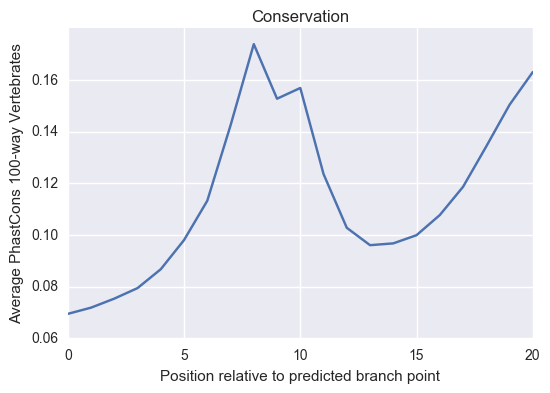

In [43]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(preds, X):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(counts / total)
plt.title('Conservation')
plt.ylabel('Average PhastCons 100-way Vertebrates')
plt.xlabel('Position relative to predicted branch point')
plt.show()

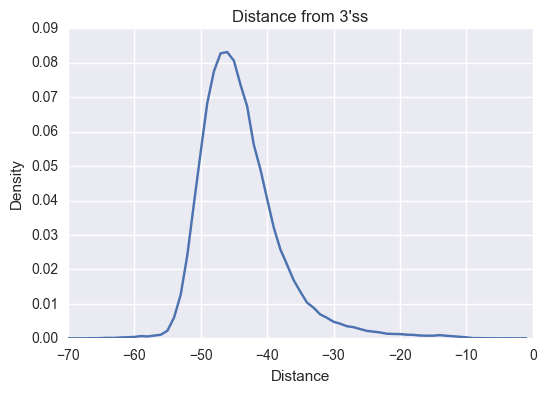

In [44]:
K = 10
counts = np.zeros((L,))
total = 0
for target in preds:
    bp = np.argmax(target)
    counts[bp] += 1
    total += 1
plt.plot(range(-70, 0), counts[::-1] / total)
plt.title("Distance from 3'ss")
plt.ylabel('Density')
plt.xlabel('Distance')
plt.show()

In [45]:
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(preds, X):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm = counts / total

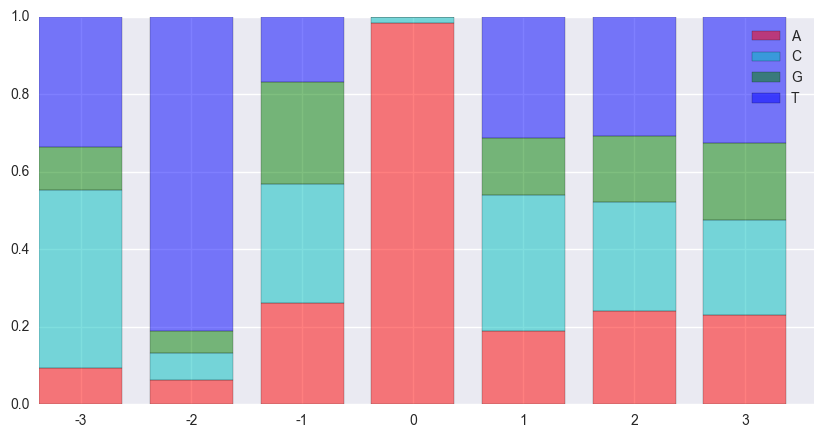

In [46]:
pwm_logo(pwm)

# Variants

In [47]:
from sklearn.utils import shuffle
import pandas
def read_variants(fn):
    return shuffle(pandas.read_csv(fn, delimiter = '\t'))

pathogenic = read_variants('../../hg19.pathogenic.exons.tsv')
benign = read_variants('../../hg19.benign.exons.tsv')

/Users/jpaggi/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Overlap BPs with HGMD, ExAC

In [48]:
# Make dict of chrom --> pos --> score
bps = {}
for chrom, pos, strand, pred in zip(chroms, coords, strands, preds):
    if chrom not in bps: bps[chrom] = {}
    for i in range(L):
        idx = pos + (i-L+1 if strand == '+' else L-i)
        if i == np.argmax(pred):
            bps[chrom][idx] = pred[i]

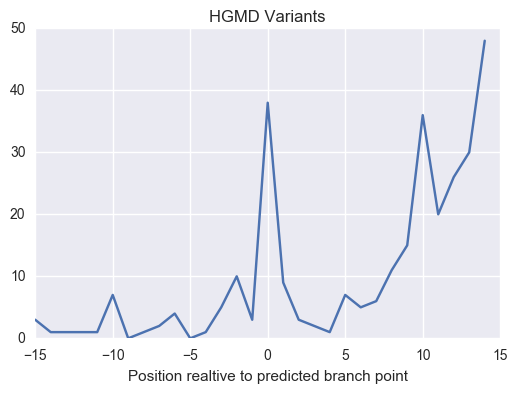

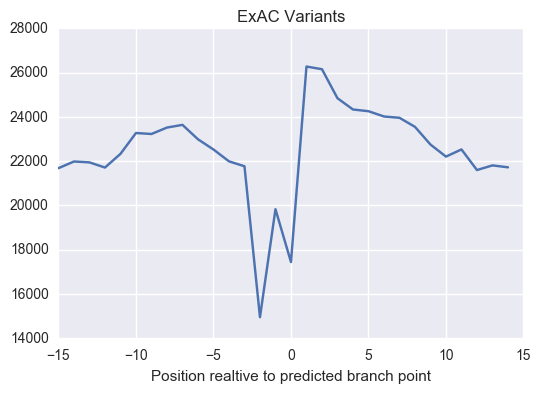

In [49]:
def var_enrichment(v, bps, title):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'], v['POS'], v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), hits)
    plt.title(title)
    plt.xlabel('Position realtive to predicted branch point')
    plt.show()
var_enrichment(pathogenic, bps, 'HGMD Variants')
var_enrichment(benign, bps, 'ExAC Variants')

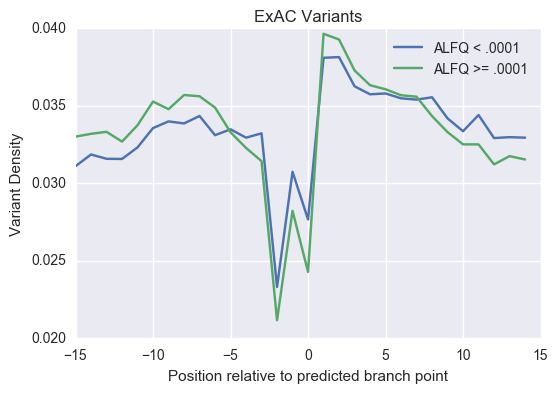

In [50]:
def var_enrichment(v, bps, label):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'],
                                      v['POS'],
                                      v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), np.array(hits)/float(sum(hits)),
             label = label)

var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps, 'ALFQ < .0001')
var_enrichment(benign[benign['ALFQMAX'] >= .0001], bps, 'ALFQ >= .0001')

plt.legend(loc = 'best')
plt.title('ExAC Variants')
plt.ylabel('Variant Density')
plt.xlabel('Position relative to predicted branch point')
plt.show()

# Apply to EVERY intron

In [51]:
X, y, chroms, coords, strands = [], [], [], [], []
for intron, bps in introns.items():
    chrom, three, strand = intron
    if strand == '+':
        begin, stop = three - L, three
    else:
        begin, stop = three, three + L
    
    # Get features
    seq = genome.get_seq(chrom, begin, stop, strand)
    if 'N' in seq: seq = seq.replace('N', 'A')
    
    c = np.array([cons[chrom][pos] if pos in cons[chrom] else 0
                  for pos in range(begin, stop)]).reshape(-1, 1)
    if strand == '-': c = c[::-1]
    
    X += [np.hstack([onehot(seq), c]).reshape(1, 70, 5)]

    # Make target
    _y = np.zeros((stop - begin,))
    for bp in bps:
        if strand == '+':
            bp = L + bp - three
        else:
            bp = L - bp + three - 1
        _y[bp] = 1
    y += [_y]
    
    chroms += [chrom]
    coords += [three]
    strands += [strand]

X, y = np.vstack(X), np.vstack(y)
print X.shape, y.shape, len(chroms)

(206292, 70, 5) (206292, 70) 206292


In [52]:
preds = model.predict(X[:, :, :4])

In [264]:
# Dump to file
with open('../anno/lstm.genomewide.tsv', 'w') as fp:
    for p, chrom, pos, strand in zip(preds, chroms, coords, strands):
        p = p.flatten()
        bp = np.argmax(p)
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        fp.write('\t'.join([chrom, str(idx), strand, str(p[bp])])+ '\n')
        
        bp = np.argmax(np.hstack([p[:bp], np.zeros((0,)), p[bp+1:]]))
        if p[bp] < .2: continue
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        fp.write('\t'.join([chrom, str(idx), strand, str(p[bp])])+ '\n')

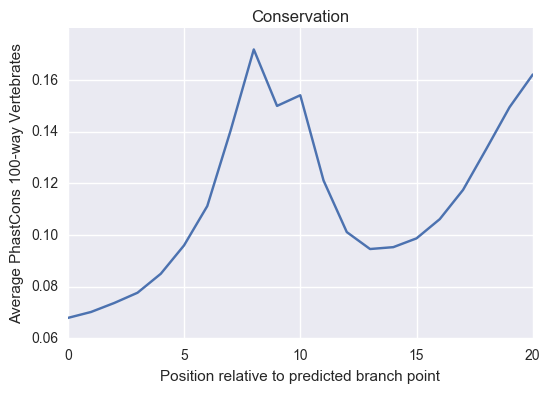

In [54]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(preds, X):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, 4]
    total += 1
plt.plot(counts / total)
plt.title('Conservation')
plt.ylabel('Average PhastCons 100-way Vertebrates')
plt.xlabel('Position relative to predicted branch point')
plt.show()

In [112]:
# Make dict of chrom --> pos --> score
bps = {}
for chrom, pos, strand, pred in zip(chroms, coords, strands, preds):
    pred = pred.flatten()
    if chrom not in bps: bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    bps[chrom][idx] = strand

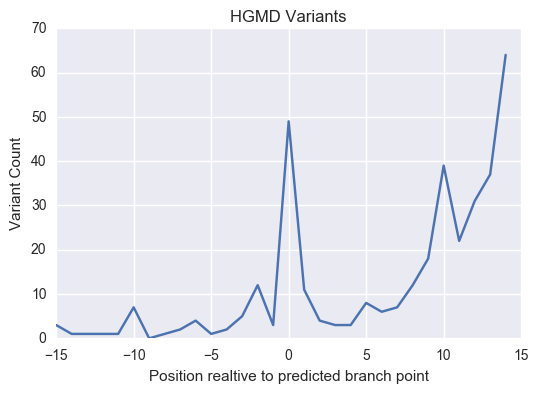

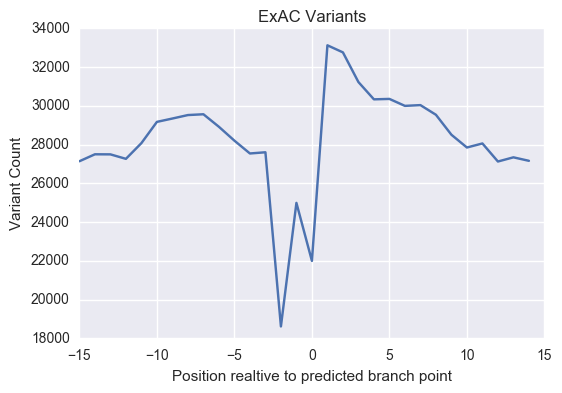

In [56]:
def var_enrichment(v, bps, title):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'], v['POS'], v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), hits)
    plt.title(title)
    plt.xlabel('Position realtive to predicted branch point')
    plt.ylabel('Variant Count')
    plt.show()
var_enrichment(pathogenic, bps, 'HGMD Variants')
var_enrichment(benign, bps, 'ExAC Variants')

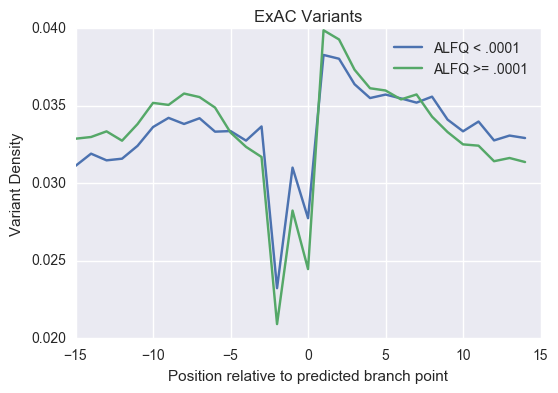

In [57]:
def var_enrichment(v, bps, label):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'],
                                      v['POS'],
                                      v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), np.array(hits)/float(sum(hits)),
             label = label)

var_enrichment(benign[benign['ALFQMAX'] <  .0001], bps, 'ALFQ < .0001')
var_enrichment(benign[benign['ALFQMAX'] >= .0001], bps, 'ALFQ >= .0001')

plt.legend(loc = 'best')
plt.title('ExAC Variants')
plt.ylabel('Variant Density')
plt.xlabel('Position relative to predicted branch point')
plt.show()

In [59]:
# Best + second best if it exceeds 0.2
# Make dict of chrom --> pos --> score
two_bps = {}
for chrom, pos, strand, pred in zip(chroms, coords, strands, preds):
    pred = pred.flatten()
    if chrom not in two_bps: two_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    two_bps[chrom][idx] = pred[i]
    
    bp = np.argmax(np.hstack([pred[:bp], np.zeros((0,)), pred[bp+1:]]))
    if pred[bp] < .2: continue
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    two_bps[chrom][idx] = pred[i]

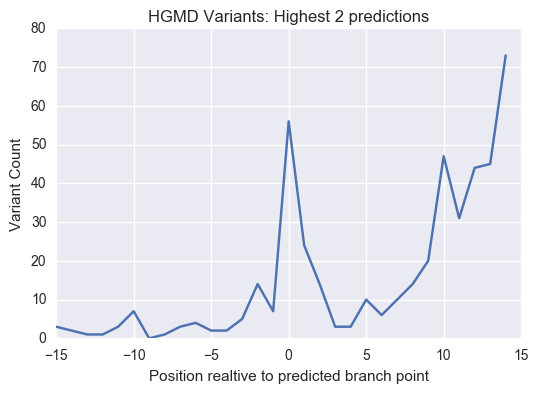

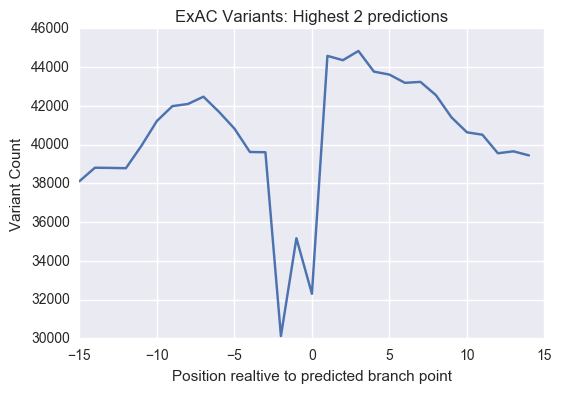

In [60]:
def var_enrichment(v, bps, title):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'], v['POS'], v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), hits)
    plt.title(title)
    plt.xlabel('Position realtive to predicted branch point')
    plt.ylabel('Variant Count')
    plt.show()

var_enrichment(pathogenic, two_bps, 'HGMD Variants: Highest 2 predictions')
var_enrichment(benign, two_bps, 'ExAC Variants: Highest 2 predictions')

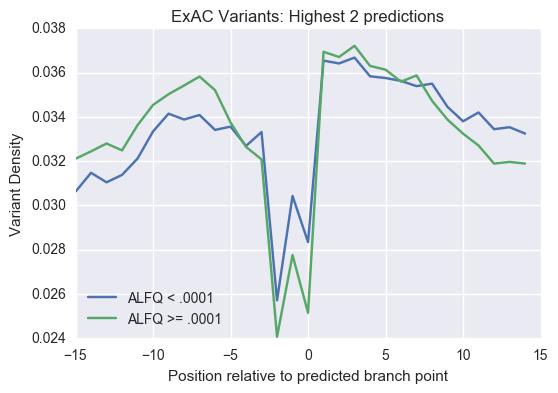

In [61]:
def var_enrichment(v, bps, label):
    hits = []
    for shift in range(-15, 15):
        hits += [0]
        for chrom, pos, strand in zip(v['# CHROM'],
                                      v['POS'],
                                      v['strand']):
            s = -shift if strand == '+' else shift
            if pos+s in bps['chr'+str(chrom)]:
                hits[-1] += 1
    plt.plot(range(-15, 15), np.array(hits)/float(sum(hits)),
             label = label)

var_enrichment(benign[benign['ALFQMAX'] <  .0001], two_bps, 'ALFQ < .0001')
var_enrichment(benign[benign['ALFQMAX'] >= .0001], two_bps, 'ALFQ >= .0001')

plt.legend(loc = 'best')
plt.title('ExAC Variants: Highest 2 predictions')
plt.ylabel('Variant Density')
plt.xlabel('Position relative to predicted branch point')
plt.show()

# Sequence context of mutated BPs

In [246]:
# Make dict of chrom --> pos --> score
mut_bps = {}
for chrom, pos, strand, pred in zip(chroms, coords, strands, preds):
    pred = pred.flatten()
    if chrom not in mut_bps: mut_bps[chrom] = {}
    bp = np.argmax(pred)
    if bp == 0: continue
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    mut_bps[chrom][idx] = [0, np.max(pred), max(np.max(pred[:bp]), np.max(pred[bp+1:]))]

for chrom, pos, strand, alfq in zip(benign['# CHROM'],
                                    benign['POS'],
                                    benign['strand'],
                                    benign['ALFQMAX']):
    shift = -2 if strand == '+' else 2
    #pos += shift
    if pos in mut_bps['chr'+str(chrom)]:
        mut_bps['chr'+str(chrom)][pos][0] = max(mut_bps['chr'+str(chrom)][pos][0], alfq)

SpearmanrResult(correlation=-0.025112768664892829, pvalue=8.1507552017994e-30)


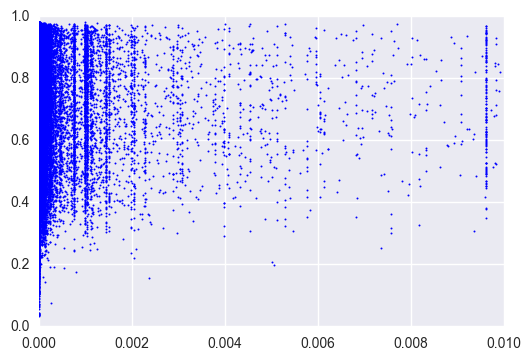

SpearmanrResult(correlation=0.017869090311449138, pvalue=7.0510511299903866e-16)


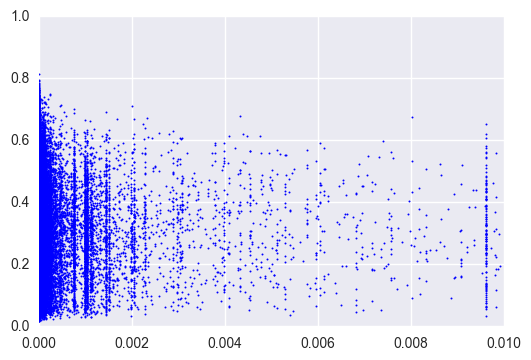

SpearmanrResult(correlation=-0.025207265853379752, pvalue=4.9993207859172612e-30)


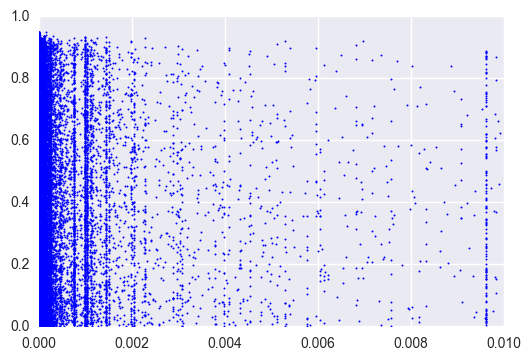

In [252]:
from scipy.stats import spearmanr

fq = [alfq for chrom, poss in mut_bps.items()
           for pos, (alfq, score1, score2) in poss.items()]
s1 = [score1 for chrom, poss in mut_bps.items()
             for pos, (alfq, score1, score2) in poss.items()]
plt.scatter(fq, s1, s = 2, lw = 0)
print spearmanr(fq, s1)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.show()

s2 = [score2 for chrom, poss in mut_bps.items()
             for pos, (alfq, score1, score2) in poss.items()]
plt.scatter(fq, s2, s = 2, lw = 0)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
print spearmanr(fq, s2)
plt.show()

s3 = np.array(s1) - np.array(s2)
plt.scatter(fq, s3, s = 2, lw = 0)
plt.xlim(0, 0.01)
plt.ylim(0, 1)
print spearmanr(fq, s3)
plt.show()

In [234]:
with open('../seqs/exac.txt', 'w') as fp:
    count = 0
    for chrom, poss in mut_bps.items():
        for pos, (alfq, strand) in poss.items():
            if not alfq:
                count += 1
                if count > 9999:
                    break
                fp.write(genome.get_seq(chrom, pos-5, pos+4, strand) + '\n')      

# Get effect on prediction for variants

In [192]:
def get_features(p):
    X_ref, X_alt, indexes = [], [], []
    for pos, shift, chrom, strand, alt in zip(p['POS'], p["3'Dist"], p['# CHROM'], p['strand'], p['ALT']):
        chrom = 'chr'+str(chrom)
        three = pos + (-shift if strand == '+' else shift-1)
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        X_ref += [onehot(seq).reshape(1, 70, 4)]
        indexes += [L+shift-1]

        altseq = (seq[:indexes[-1]]
                  + (alt if strand == '+' else genome.revcomp(alt))
                  + seq[indexes[-1]+1:])
        X_alt += [onehot(altseq).reshape(1, 70, 4)]

    return np.vstack(X_ref), np.vstack(X_alt), np.array(indexes)

def get_stats(ref, alt, indexs):
    delta = []
    for r, a in zip(ref, alt):
        bp = np.argmax(r)
        delta += [a[bp] - r[bp]]
    delta = np.array(delta)
    max_delta = np.max(alt, axis = 1) - np.max(ref, axis = 1)
    shift = indexs - np.argmax(ref, axis =1)
    return shift, delta, max_delta

In [265]:
p = pathogenic[(pathogenic["3'Dist"] > -45) & (pathogenic["3'Dist"] <= -18)]

path_X_ref, path_X_alt, path_indexes = get_features(p)

path_shift, path_delta, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                   model.predict(path_X_alt).reshape(-1, L),
                                                   path_indexes)

b = benign[(benign["3'Dist"] > -45) & (benign["3'Dist"] <= -18)][:1000]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                         model.predict(benign_X_alt).reshape(-1, L),
                                                         benign_indexes)

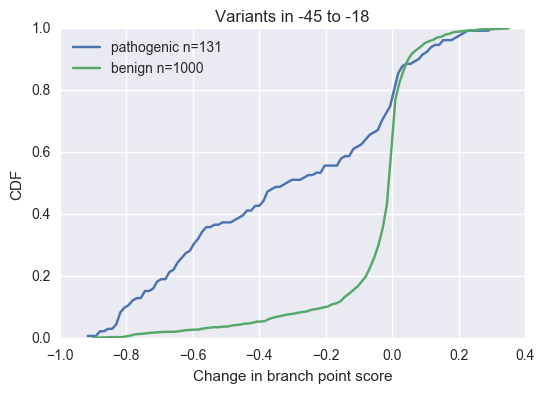

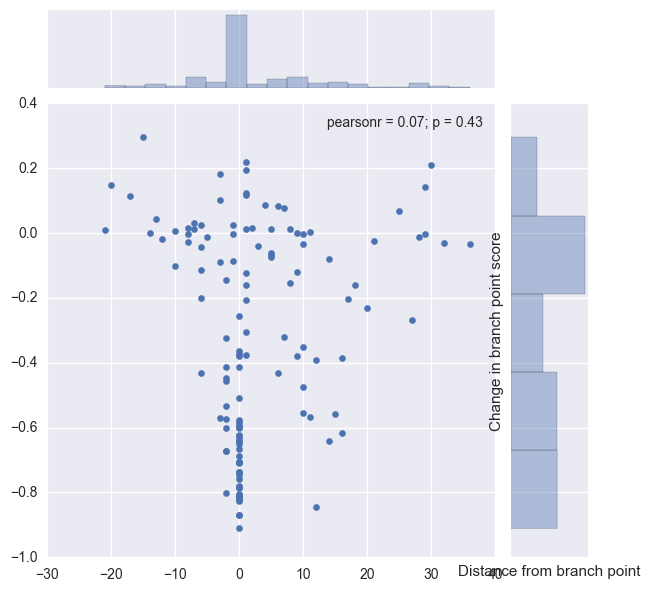

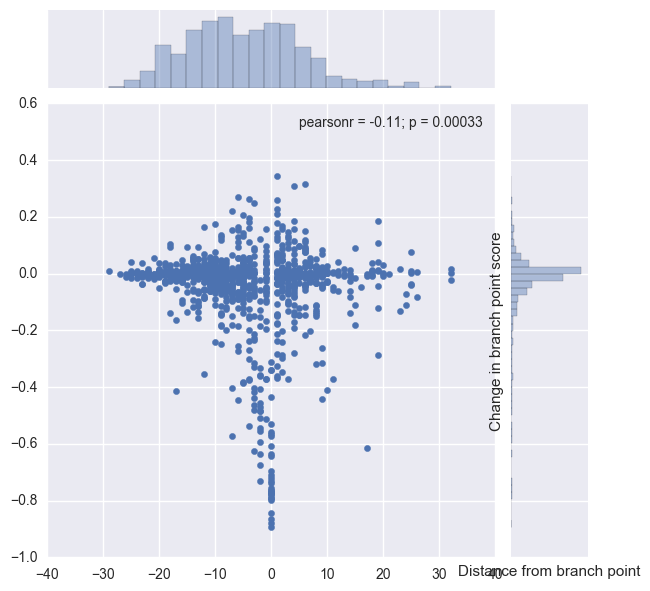

In [272]:
from scipy.stats import cumfreq
def cdf(a, label, bins = 100):
    c = cumfreq(a, bins)
    lower = c.lowerlimit
    upper = lower + bins * c.binsize
    plt.plot(np.linspace(lower, upper, bins),
             c.cumcount / a.shape[0],
             label = label)
    
def compare_cdfs(path, benign, title, xlabel):
    cdf(path, "pathogenic n={}".format(path.shape[0]))
    cdf(benign, "benign n={}".format(benign.shape[0]))
    plt.legend()
    plt.ylabel('CDF')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend(loc = 'best')
    plt.show()
    
compare_cdfs(path_delta, benign_delta, 'Variants in -45 to -18', 'Change in branch point score')
sns.jointplot(path_shift, path_delta)

# For use in pathogenicity predictor

In [262]:
p = pathogenic[(pathogenic["3'Dist"] > -50) & (pathogenic["3'Dist"] <= -6)]

path_X_ref, path_X_alt, path_indexes = get_features(p)

path_shift, path_delta, path_max_delta = get_stats(model.predict(path_X_ref).reshape(-1, L),
                                                   model.predict(path_X_alt).reshape(-1, L),
                                                   path_indexes)

b = benign[(benign["3'Dist"] > -50) & (benign["3'Dist"] <= -6)]

benign_X_ref, benign_X_alt, benign_indexes = get_features(b)

benign_shift, benign_delta, benign_max_delta = get_stats(model.predict(benign_X_ref).reshape(-1, L),
                                                         model.predict(benign_X_alt).reshape(-1, L),
                                                         benign_indexes)

In [263]:
with open('../../path.bp.txt', 'w') as fp:
    for chrom, pos, pred in zip(p['# CHROM'], p['POS'], path_delta):
        fp.write('\t'.join([chrom, str(pos), str(pred)])+'\n')
        
with open('../../benign.bp.txt', 'w') as fp:
    for chrom, pos, pred in zip(b['# CHROM'], b['POS'], benign_delta):
        fp.write('\t'.join([str(chrom), str(pos), str(pred)])+'\n')